# **Check GPU**

In [6]:
import sys
import psutil
import os

In [2]:
if 'google.colab' in sys.modules:
    print("✅ You are running in Google Colab")
    print(f"📍 Python version: {sys.version}")
else:
    print("⚠️ You are not running in Google Colab")
    print("This notebook is designed to run in Colab")

✅ You are running in Google Colab
📍 Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [3]:
# Information about RAM
ram_gb = psutil.virtual_memory().total / (1024**3)
print(f"💾 Total RAM: {ram_gb:.2f} GB")

# Information about CPU
cpu_count = psutil.cpu_count()
print(f"⚙️ CPUs available: {cpu_count}")

# Check GPU
gpu_info = !nvidia-smi --query-gpu=name,memory.total --format=csv,noheader 2>/dev/null
if gpu_info:
    print(f"🎮 GPU: {gpu_info[0]}")
else:
    print("⚠️ Not GPU available (using CPU)")

🎮 GPU: Tesla T4, 15360 MiB


In [5]:
!nvidia-smi

Thu Dec 11 19:25:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **Preliminares**

In [7]:
!pip install torchinfo optuna botorch gpytorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 78.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.6/280.6 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 5.4 MB/s eta 0:00:00


In [8]:
!git clone https://github.com/ealeongomez/RFF-HBO-TSF.git

Cloning into 'RFF-HBO-TSF'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 68 (delta 22), reused 38 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 24.61 MiB | 5.85 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [9]:
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, pickle
import pprint
from tqdm import tqdm
from scipy.interpolate import griddata
from collections import defaultdict
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchinfo import summary
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

import optuna
import optuna.visualization as vis
import optuna.importance
#from optuna_integration.botorch import BoTorchSampler
from optuna.samplers import TPESampler
from optuna.samplers import GPSampler
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_parallel_coordinate
from optuna.pruners import MedianPruner

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor

import warnings
warnings.filterwarnings("ignore")

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
n_trials_per_type = 5

# **Load dataset**

In [11]:
def detect_environment():
    # Kaggle
    if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
        return "Kaggle"

    # Google Colab
    try:
        import google.colab
        pkl_filename = "/content/RFF-HBO-TSF/Data/data_dict.pkl"
        return "Google Colab", pkl_filename
    except ImportError:
        pass
    # Local u otro entorno
    return "Local/Other"

value_, pkl_filename = detect_environment()

print("Entorno detectado:", value_)


Entorno detectado: Google Colab


In [12]:
with open(pkl_filename, "rb") as f:
    data_dict_loaded = pickle.load(f)

In [13]:
def make_loader(X_arr, y_arr, batch_size, shuffle=False):
    ds = TensorDataset(torch.tensor(X_arr, dtype=torch.float32), torch.tensor(y_arr, dtype=torch.float32))
    return DataLoader(ds, batch_size=batch_size, shuffle=False)

In [14]:
data_dict_loaded.keys()

dict_keys(['Etiopia-April', 'Etiopia-May', 'Argone', 'Beijing', 'Chengdu', 'Netherland-0', 'Netherland-1', 'Netherland-2', 'Lorenz systems 0.5', 'Lorenz systems 3', 'Lorenz systems 5'])

In [15]:
names_TSF = ['Netherland-2']

In [16]:
data_dict_loaded[names_TSF[0]].keys()

dict_keys(['X', 'Y', 'time_series', 'Max'])

In [17]:
data_dict_loaded[names_TSF[0]]['Max']

np.float64(1.0)

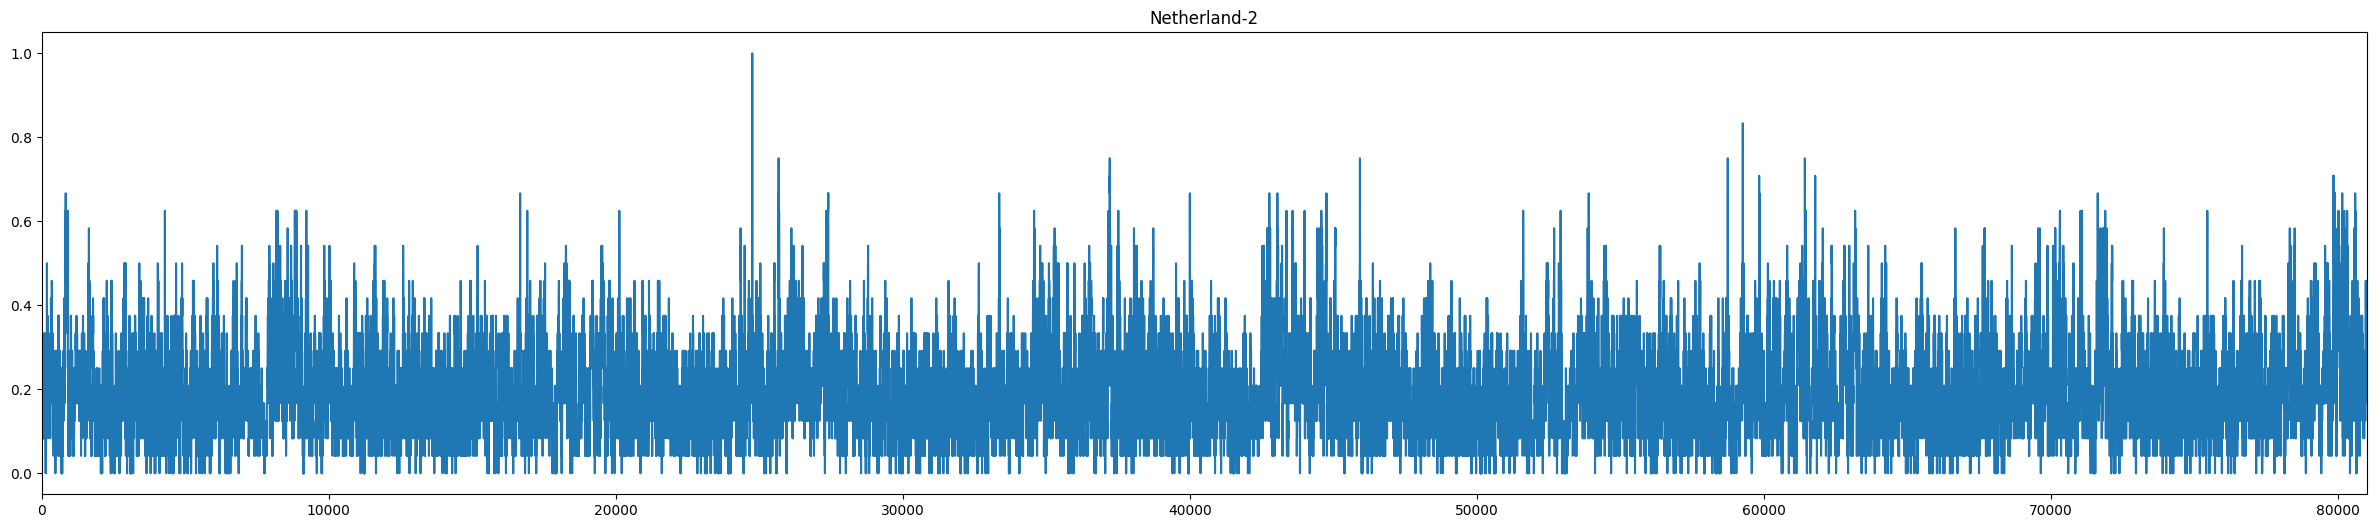

In [18]:
plt.figure(figsize=(30, 6))
plt.plot(data_dict_loaded[names_TSF[0]]['time_series'])
plt.title(names_TSF[0])
plt.xlim(0, len(data_dict_loaded[names_TSF[0]]['time_series']))
plt.show()

In [19]:
data = {}

for folder_name in names_TSF:
    print(f"\nFolder: {folder_name}")

    # Inicializar sección
    data[folder_name] = {}

    X = data_dict_loaded[f"{folder_name}"]['X']
    Y = data_dict_loaded[f"{folder_name}"]['Y']

    print(X.shape, Y.shape)

    X = X[..., np.newaxis]  # Expand dims for CNN

    print(X.shape, Y.shape)

    # Train/Validation/Test splits
    X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

    if folder_name == "Etiopia-April" or folder_name == "Etiopia-May":
        batch_size = 64
    else:
        batch_size = 256

    train_loader = make_loader(X_train, y_train, batch_size)
    valid_loader = make_loader(X_valid, y_valid, batch_size)
    test_loader  = make_loader(X_test,  y_test, batch_size)

    data[folder_name] = {"loaders": {"train": train_loader, "valid": valid_loader, "test":  test_loader}}


Folder: Netherland-2
(80979, 10) (80979, 10)
(80979, 10, 1) (80979, 10)


In [20]:
batch = next(iter(data[folder_name]["loaders"]["train"]))
if isinstance(batch, (list, tuple)):
    _, y_sample = batch
else:
    y_sample = batch["y"]
H = y_sample.shape[1]
print(f"Usando dataset: {folder_name} | Horizonte H={H}")

Usando dataset: Netherland-2 | Horizonte H=10


# **Models**

## Tradictional

In [21]:
class PlainRNN_Forecaster(nn.Module):
    """
    Modelo recurrente tradicional para predicción multihorizonte.
    Compatible con RNN, GRU y LSTM.

    Ecuación general:
        h_t = f(W_xh * x_t + W_hh * h_{t-1} + b)
        ŷ = W_hy * h_T + b_y

    Parámetros:
        horizon: número de pasos de predicción
        rnn_type: "RNN", "GRU" o "LSTM"
        hidden: tamaño del estado oculto
        num_layers: número de capas recurrentes
        bidirectional: True/False
        pool: "last" o "mean"
    """
    def __init__(self, horizon=24, rnn_type="RNN", hidden=64,
                 num_layers=1, bidirectional=False, pool="last"):
        super().__init__()

        self.horizon = horizon
        self.rnn_type = rnn_type
        self.hidden = hidden
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.pool = pool

        # Capa recurrente pura
        self.rnn = getattr(nn, rnn_type)(
            input_size=1,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        # Capa lineal final
        out_dim = hidden * (2 if bidirectional else 1)
        self.fc = nn.Linear(out_dim, horizon)

    def forward(self, x):
        """
        x: [B, T, 1]
        Salida: [B, horizon]
        """
        H, _ = self.rnn(x)  # [B, T, hidden]
        if self.pool == "mean":
            v = H.mean(dim=1)        # promedio temporal
        else:
            v = H[:, -1, :]          # último estado
        y_hat = self.fc(v)
        return y_hat

## Proposal

In [22]:
class DenseRFF_PT(nn.Module):
    """
    Implementación de Random Fourier Features (RFF)
    - Compatible con kernel gaussiano o laplaciano.
    - Proyección: Φ(x) = sqrt(2/Nf) * cos(Wx + b)
    - Soporta parámetros entrenables para escala espectral.
    """
    def __init__(self, Nf, scale=None, gamma=None, normalization=True,
                 function="cos", trainable_scale=True, trainable_W=True,
                 seed=None, kernel='gaussian'):
        super().__init__()
        self.Nf = Nf
        self.gamma = gamma
        self.scale = scale
        self.normalization = normalization
        self.function = function
        self.trainable_scale = trainable_scale
        self.trainable_W = trainable_W
        self.seed = seed
        self.kernel_type = kernel

        # Inicialización diferida
        self.W = None
        self.b = None
        self.rho_scale = None
        self._eps = 1e-8
        self.bandwidth_history = []

    def _get_random_features_initializer(self, shape, sigma=1.0, seed=None):
        if seed is not None:
            np.random.seed(seed)
        if self.kernel_type == 'gaussian':
            return np.random.randn(*shape) / sigma
        elif self.kernel_type == 'laplacian':
            return np.random.laplace(loc=0.0, scale=1.0, size=shape) / sigma
        else:
            raise ValueError(f'Unsupported initializer {self.kernel_type}')

    def _ensure_params_initialized(self, device, D):
        if self.W is None:
            if self.gamma is not None:
                sigma = np.sqrt(1.0 / (2 * self.gamma))
            else:
                sigma = 1.0
            if self.scale is None:
                self.scale = sigma

            W_init = self._get_random_features_initializer((D, self.Nf),
                                                           sigma=self.scale,
                                                           seed=self.seed)
            self.W = nn.Parameter(torch.tensor(W_init, dtype=torch.float32, device=device),
                                  requires_grad=self.trainable_W)

            b_init = np.random.uniform(0.0, 2 * np.pi, size=(self.Nf,))
            self.b = nn.Parameter(torch.tensor(b_init, dtype=torch.float32, device=device),
                                  requires_grad=self.trainable_W)

            init_kernel_scale = 1.0
            rho0 = np.log(np.exp(init_kernel_scale) - 1.0)
            self.rho_scale = nn.Parameter(
                torch.tensor([rho0], dtype=torch.float32, device=device),
                requires_grad=self.trainable_scale
            )

    def _kernel_scale(self):
        return F.softplus(self.rho_scale) + self._eps

    def bandwidth_lengthscale(self):
        if self.rho_scale is None or self.scale is None:
            return None
        ks = float(self._kernel_scale().detach().cpu().item())
        return float(self.scale) / ks

    @torch.no_grad()
    def log_bandwidth(self, step):
        ell = self.bandwidth_lengthscale()
        if ell is not None:
            self.bandwidth_history.append((step, float(ell)))

    def forward(self, inputs):
        device = inputs.device
        if inputs.dim() == 2:
            inputs = inputs.unsqueeze(1)
        elif inputs.dim() != 3:
            raise ValueError(f"Expected [B,T,D], got {inputs.shape}")

        B, T, D = inputs.shape
        self._ensure_params_initialized(device, D)
        kernel_scale = self._kernel_scale()

        proj = torch.matmul(inputs, self.W * kernel_scale) + self.b
        outputs = torch.cos(proj) * np.sqrt(2.0 / self.Nf)

        if self.normalization:
            norm = np.sqrt(self.Nf)
            outputs = outputs / norm

        return outputs.permute(0, 2, 1)  # [B, Nf, T]

In [23]:
class SpectralDropout1d(nn.Module):
    def __init__(self, p: float = 0.1, channels_last: bool = True):
        super().__init__()
        self.p = p
        self.channels_last = channels_last
    def forward(self, x):
        if (not self.training) or self.p == 0.0:
            return x
        if self.channels_last:
            B, T, F = x.shape
            mask = (torch.rand(B, 1, F, device=x.device) > self.p).float() / (1.0 - self.p)
            return x * mask
        else:
            B, F, T = x.shape
            mask = (torch.rand(B, F, 1, device=x.device) > self.p).float() / (1.0 - self.p)
            return x * mask

In [24]:
class TemporalSpectralBlock(nn.Module):
    """
    Bloque temporal convolucional dilatado con residual y normalización.
    Garantiza longitudes compatibles mediante recorte dinámico.
    """
    def __init__(self, features, kernel_size=3, dilation=2, p_drop=0.1):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2
        self.conv1 = nn.Conv1d(features, features, kernel_size, padding=padding, dilation=dilation)
        self.conv2 = nn.Conv1d(features, features, kernel_size, padding=padding, dilation=1)
        self.norm = nn.LayerNorm(features)
        self.act = nn.GELU()
        self.drop = nn.Dropout(p_drop)

    def forward(self, x):  # [B,T,F]
        res = x
        y = x.transpose(1, 2)          # [B,F,T]
        y = self.act(self.conv1(y))
        y = self.conv2(y).transpose(1, 2)  # [B,T',F]
        # Ajuste de longitud si hay diferencia
        if y.size(1) != res.size(1):
            min_len = min(y.size(1), res.size(1))
            y = y[:, :min_len, :]
            res = res[:, :min_len, :]
        y = self.norm(y + res)
        y = self.act(y)
        return self.drop(y)

In [25]:
class MultiBandRFFEncoder(nn.Module):
    """
    Aplica DenseRFF_PT sobre múltiples bandas de escala y concatena las salidas.
    Entrada: [B, T, D]
    Salida: [B, T, F_total]
    """
    def __init__(self, in_dim=1, bands=(4., 24., 168.), nf_per_band=32,
                 kernel="gaussian", spectral_dropout_p=0.1):
        super().__init__()
        self.bands = nn.ModuleList([
            DenseRFF_PT(Nf=nf_per_band, function="cos",
                        trainable_W=True, trainable_scale=True,
                        kernel=kernel, scale=band)
            for band in bands
        ])
        self.out_dim = nf_per_band * len(self.bands)
        self.norm = nn.LayerNorm(self.out_dim)
        self.spec_do = SpectralDropout1d(p=spectral_dropout_p, channels_last=True)
        self.drop = nn.Dropout(spectral_dropout_p)

    def forward(self, x):
        outs = []
        for b in self.bands:
            z = b(x)                    # [B, Nf, T]
            z = z.transpose(1, 2)       # [B, T, Nf]
            outs.append(z)
        zcat = torch.cat(outs, dim=2)   # [B, T, F_total]
        zcat = self.norm(zcat)
        zcat = self.drop(self.spec_do(zcat))
        return zcat

In [26]:
class TemporalHead(nn.Module):
    """Pooling temporal + proyección final."""
    def __init__(self, hidden, horizon, pool="last"):
        super().__init__()
        self.pool = pool
        self.fc1 = nn.Linear(hidden, hidden // 2)
        self.fc2 = nn.Linear(hidden // 2, horizon)
        self.act = nn.ReLU()

    def forward(self, H):
        if self.pool == "mean":
            v = H.mean(dim=1)
        else:
            v = H[:, -1, :]
        return self.fc2(self.act(self.fc1(v)))

In [27]:
class RFF_AnyRNN_Forecaster(nn.Module):
    """
    Arquitectura general con codificación RFF + bloque temporal + RNN/GRU/LSTM.
    """
    def __init__(self, horizon=24, rnn_type="RNN",
                 bands=(4., 24., 168.), nf_per_band=64,
                 hidden=96, num_layers=1, bidirectional=False,
                 use_tsb=True, kernel="gaussian",
                 spectral_dropout_p=0.1, pool="last"):
        super().__init__()
        # --- Codificador espectral ---
        self.enc = MultiBandRFFEncoder(1, bands, nf_per_band, kernel, spectral_dropout_p)
        # --- Bloque temporal convolucional ---
        self.tsb = TemporalSpectralBlock(self.enc.out_dim) if use_tsb else nn.Identity()
        # --- RNN parametrizable ---
        self.rnn = getattr(nn, rnn_type)(
            input_size=self.enc.out_dim,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )
        # --- Proyección final ---
        out_hidden = hidden * (2 if bidirectional else 1)
        self.head = TemporalHead(out_hidden, horizon, pool)

    def forward(self, x):
        z = self.enc(x)       # [B,T,F]
        z = self.tsb(z)       # [B,T,F]
        H, _ = self.rnn(z)    # [B,T,H]
        return self.head(H)   # [B,H]

# **Train**

In [28]:
class TotalLoss(nn.Module):
    def __init__(self, alpha_spec: float = 0.0, alpha_weight: float = 0.0):
        super().__init__()
        self.mse = nn.MSELoss()
        # alpha_* quedan ignorados en el baseline tradicional

    def forward(self, y_true, y_pred):
        # train_model llama criterion(yb, preds): (y_true, y_pred)
        return F.mse_loss(y_pred, y_true)

def ts_augment(x):
    return x

In [29]:
def train_model(model, data, folder_name, num_epochs=50, lr=1e-3, device="cuda", trial=None, lr_rho_multiplier: float = 1.0, log_per_batch: bool = False):
    """
    Versión mejorada con:
      ✅ Compatibilidad con nuevas clases (RecurrentRFFForecast, MultiScaleRFF)
      ✅ Data augmentation temporal (ts_augment)
      ✅ Pérdida combinada TotalLoss (Huber ponderado + Espectral)
      ✅ Logging automático de ℓ (bandwidth) si el modelo usa RFF
    """
    from collections import defaultdict
    import torch.optim as optim
    import matplotlib.pyplot as plt
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

    loaders = data[folder_name]["loaders"]
    train_loader = loaders["train"]
    valid_loader = loaders["valid"]
    test_loader  = loaders["test"]

    # =============================================================
    # Helpers internos
    # =============================================================
    def _iter_rff_modules(m):
        """Detecta módulos tipo RFF (DenseRFF_PT o MultiScaleRFF)."""
        target_class_names = ["DenseRFF_PT", "MultiScaleRFF"]
        for sub in m.modules():
            name_ok = (sub.__class__.__name__ in target_class_names)
            has_attrs = any(hasattr(sub, a) for a in ["kernel_scale", "bandwidth_lengthscale", "log_bandwidth", "scale"])
            if name_ok or has_attrs:
                yield sub

    def _safe_item(x):
        try:
            return float(x.detach().cpu().item())
        except Exception:
            try:
                return float(x)
            except Exception:
                return None

    def _compute_ell_if_possible(rff):
        """Intenta obtener una 'longitud de banda' interpretable."""
        if hasattr(rff, "bandwidth_lengthscale"):
            try:
                ell = rff.bandwidth_lengthscale()
                if isinstance(ell, (list, tuple)):
                    ell = ell[0]
                return _safe_item(ell)
            except Exception:
                pass

        try:
            scale = getattr(rff, "scale", None)
            ksc   = getattr(rff, "kernel_scale", None)
            if scale is not None and ksc is not None:
                scale = _safe_item(scale)
                ksc   = _safe_item(ksc)
                if scale is not None and ksc is not None and ksc != 0.0:
                    return scale / ksc
        except Exception:
            pass

        return None

    # =============================================================
    # Inicialización de modelo y optimizador
    # =============================================================
    xb0, yb0 = next(iter(train_loader))
    window  = int(xb0.shape[1])
    horizon = int(yb0.shape[1])

    if hasattr(model, "fc2") and isinstance(model.fc2, nn.Linear) and model.fc2.out_features != horizon:
        model.fc2 = nn.Linear(model.fc2.in_features, horizon).to(device)

    model = model.to(device)

    with torch.no_grad():
        _ = model(xb0.to(device))

    named = list(model.named_parameters())
    rho_params   = [p for n, p in named if "rho_scale" in n and p.requires_grad]
    other_params = [p for n, p in named if "rho_scale" not in n and p.requires_grad]

    if lr_rho_multiplier != 1.0 and len(rho_params) > 0:
        optimizer = optim.Adam(
            [{"params": rho_params, "lr": lr * lr_rho_multiplier},
             {"params": other_params, "lr": lr}]
        )
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)

    # ✅ Pérdida híbrida
    criterion = TotalLoss(alpha_spec=1e-3, alpha_weight=0.05)

    best_val = float("inf")
    history = {"train_loss": [], "valid_loss": []}

    # Detectar RFFs una sola vez (tras warm-up)
    rff_modules = list(_iter_rff_modules(model))
    has_rff = len(rff_modules) > 0
    ell_series = defaultdict(list)
    rff_names = {id(m): f"RFF_{i+1}_{m.__class__.__name__}" for i, m in enumerate(rff_modules)}

    def _log_bandwidths(step):
        """Calcula y guarda ℓ por cada capa RFF si es posible."""
        for m in rff_modules:
            ell = _compute_ell_if_possible(m)
            if ell is not None and np.isfinite(ell):
                ell_series[rff_names[id(m)]].append((step, float(ell)))
            if hasattr(m, "log_bandwidth"):
                try:
                    m.log_bandwidth(step=step)
                except Exception:
                    pass

    # =============================================================
    # Loop de entrenamiento
    # =============================================================
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0
        for batch_idx, (xb, yb) in enumerate(train_loader, start=1):
            xb, yb = xb.to(device), yb.to(device)

            # 🔹 Augmentación temporal
            xb = ts_augment(xb)

            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(yb, preds)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item() * xb.size(0)

            if log_per_batch and has_rff:
                global_step = (epoch - 1) * len(train_loader) + batch_idx
                _log_bandwidths(step=global_step)

        train_loss /= len(train_loader.dataset)

        # -------- Validación --------
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for xb, yb in valid_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(yb, preds)
                valid_loss += loss.item() * xb.size(0)
        valid_loss /= len(valid_loader.dataset)

        history["train_loss"].append(train_loss)
        history["valid_loss"].append(valid_loss)

        if has_rff and not log_per_batch:
            _log_bandwidths(step=epoch)

        if epoch % 10 == 0:
            msg = f"Epoch {epoch:03d} | Train {train_loss:.4f} | Valid {valid_loss:.4f}"
            if has_rff:
                name0 = next(iter(rff_names.values()))
                last_series = ell_series.get(name0, [])
                if last_series:
                    msg += f" | ℓ={last_series[-1][1]:.4f}"
            print(msg)

        if valid_loss < best_val:
            best_val = valid_loss
            torch.save(model.state_dict(), f"best_model_{folder_name}.pth")

        if (trial is not None) and ("optuna" in globals()):
            trial.report(-valid_loss, step=epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

    # =============================================================
    # Test y métricas
    # =============================================================
    model.load_state_dict(torch.load(f"best_model_{folder_name}.pth", map_location=device))
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            y_true.append(yb.cpu())
            y_pred.append(preds.cpu())

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    # --- Global ---
    r2   = float(r2_score(y_true, y_pred))
    mae  = float(mean_absolute_error(y_true, y_pred))
    mse  = float(mean_squared_error(y_true, y_pred))
    rmse = float(np.sqrt(mse))
    print(f"Test GLOBAL | R2={r2:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f}")

    # --- Por horizonte ---
    H = y_true.shape[1]
    metrics_pointwise = {"horizon": [], "RMSE": [], "MAE": [], "R2": []}
    for h in range(H):
        yt = y_true[:, h]
        yp = y_pred[:, h]
        mse_h = mean_squared_error(yt, yp)
        rmse_h = np.sqrt(mse_h)
        mae_h  = mean_absolute_error(yt, yp)
        r2_h   = r2_score(yt, yp)
        metrics_pointwise["horizon"].append(h+1)
        metrics_pointwise["RMSE"].append(float(rmse_h))
        metrics_pointwise["MAE"].append(float(mae_h))
        metrics_pointwise["R2"].append(float(r2_h))
    df_pointwise = pd.DataFrame(metrics_pointwise)

    # --- Acumuladas ---
    metrics_cumulative = {"horizon": [], "RMSE": [], "MAE": [], "R2": []}
    for h in range(1, H+1):
        yt = y_true[:, :h].reshape(-1)
        yp = y_pred[:, :h].reshape(-1)
        mse_h = mean_squared_error(yt, yp)
        rmse_h = np.sqrt(mse_h)
        mae_h  = mean_absolute_error(yt, yp)
        r2_h   = r2_score(yt, yp)
        metrics_cumulative["horizon"].append(h)
        metrics_cumulative["RMSE"].append(float(rmse_h))
        metrics_cumulative["MAE"].append(float(mae_h))
        metrics_cumulative["R2"].append(float(r2_h))
    df_cumulative = pd.DataFrame(metrics_cumulative)

    # --- Logging de bandwidth ---
    """
    if has_rff and any(len(v) > 0 for v in ell_series.values()):
        x_label = "Step" if log_per_batch else "Epoch"
        for name, series in ell_series.items():
            if not series:
                continue
            steps, ells = zip(*series)
            plt.figure()
            plt.plot(steps, ells, marker="o")
            plt.xlabel(x_label)
            plt.ylabel("Bandwidth ℓ (aprox.)")
            plt.title(f"Evolución del ancho de banda — {name}")
            plt.tight_layout()
            out_fig = f"bandwidth_evolution_{folder_name}_{name}.png"
            plt.savefig(out_fig, dpi=150)
            print(f"[OK] Guardado: {out_fig}")

    # --- Bandwidth logging: unified plot for all RFF layers ---
    if has_rff and any(len(v) > 0 for v in ell_series.values()):

        x_label = "Step" if log_per_batch else "Epoch"

        plt.figure(figsize=(10, 5))

        for module in rff_modules:
            key = rff_names[id(module)]
            series = ell_series[key]
            if not series:
                continue

            steps, ells = zip(*series)

            clean_name = key.replace(".", " → ")

            # --- Read actual mapping dimension ---
            Nf_value = getattr(module, "Nf", "?")

            legend_label = f"{clean_name} (Nf={Nf_value})"

            plt.plot(
                steps,
                ells,
                marker="o",
                linewidth=2,
                markersize=4,
                alpha=0.85,
                label=legend_label
            )

        plt.xlabel(x_label)
        plt.ylabel("Bandwidth ℓ (approx.)")
        plt.title(f"Bandwidth Evolution Across All RFF Layers\nDataset: {folder_name}")
        plt.legend(title="RFF Layers", loc="best")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        out_fig = f"bandwidth_evolution_ALL_RFF_{folder_name}.png"
        plt.savefig(out_fig, dpi=150)
        plt.close()

        print(f"[OK] Saved unified bandwidth plot: {out_fig}")
        """
    # --- ---
    if has_rff and any(len(v) > 0 for v in ell_series.values()):

        x_label = "Step" if log_per_batch else "Epoch"

        # --- Square figure ---
        fig, ax1 = plt.subplots(figsize=(10, 7))

        # Additional y-axes
        ax2 = ax1.twinx()
        ax3 = ax1.twinx()
        ax3.spines["right"].set_position(("axes", 1.18))  # shift right

        # Colors
        color_small  = "tab:blue"
        color_medium = "tab:green"
        color_large  = "tab:red"

        # ============================================================
        # Classify layers into small/medium/large ℓ groups
        # ============================================================
        avg_ells = [np.mean([v for _, v in s]) for s in ell_series.values() if len(s) > 0]
        p33, p66 = np.percentile(avg_ells, [33, 66])

        groups = {"small": [], "medium": [], "large": []}

        for module in rff_modules:
            key = rff_names[id(module)]
            series = ell_series[key]
            if not series:
                continue

            steps, ells = zip(*series)
            ells = np.array(ells)
            mean_ell = float(np.mean(ells))
            Nf_value = getattr(module, "Nf", "?")

            if mean_ell < p33:
                groups["small"].append((key, steps, ells, Nf_value))
            elif mean_ell < p66:
                groups["medium"].append((key, steps, ells, Nf_value))
            else:
                groups["large"].append((key, steps, ells, Nf_value))

        # ============================================================
        # Plot SMALL scale ℓ — ax1
        # ============================================================
        # Extract Nf for label (median Nf in this group)
        small_Nf = np.median([g[3] for g in groups["small"]]) if groups["small"] else "?"

        for key, steps, ells, Nf_value in groups["small"]:
            ax1.plot(
                steps, ells,
                marker="o", linewidth=2.7, markersize=6,
                label=f"{key} — Nf={Nf_value}",
                color=color_small, alpha=0.92
            )

        ax1.set_xlabel(x_label, fontsize=18)
        ax1.set_ylabel(f"$\mathbf{{\\varphi}}$ (small scale) — Nf={small_Nf}", color=color_small, fontsize=18)
        ax1.tick_params(axis="x", labelsize=16)
        ax1.tick_params(axis="y", labelcolor=color_small, labelsize=16)
        ax1.grid(True, linestyle="--", alpha=0.35)

        # ============================================================
        # Plot MEDIUM scale ℓ — ax2
        # ============================================================
        medium_Nf = np.median([g[3] for g in groups["medium"]]) if groups["medium"] else "?"

        for key, steps, ells, Nf_value in groups["medium"]:
            ax2.plot(
                steps, ells,
                marker="s", linewidth=2.7, markersize=6,
                label=f"{key} — Nf={Nf_value}",
                color=color_medium, alpha=0.92
            )

        #ax2.set_ylabel(f"\varphi (medium scale) — Nf={medium_Nf}",
        #              color=color_medium, fontsize=18)
        ax2.set_ylabel(f"$\mathbf{{\\varphi}}$ (medium scale) — Nf={small_Nf}",
                      color=color_medium, fontsize=18)

        ax2.tick_params(axis="y", labelcolor=color_medium, labelsize=16)

        # ============================================================
        # Plot LARGE scale ℓ — ax3
        # ============================================================
        large_Nf = np.median([g[3] for g in groups["large"]]) if groups["large"] else "?"

        for key, steps, ells, Nf_value in groups["large"]:
            ax3.plot(
                steps, ells,
                marker="^", linewidth=2.7, markersize=6,
                label=f"{key} — Nf={Nf_value}",
                color=color_large, alpha=0.92
            )

        ax3.set_ylabel(f"$\mathbf{{\\varphi}}$ (large scale) — Nf={large_Nf}",
                      color=color_large, fontsize=18)
        ax3.tick_params(axis="y", labelcolor=color_large, labelsize=16)

        # ============================================================
        # Unified Legend (all layers + Nf)
        # ============================================================
        handles, labels = [], []
        for ax in [ax1, ax2, ax3]:
            h, l = ax.get_legend_handles_labels()
            handles += h
            labels  += l

        fig.legend(
            handles, labels,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.08),
            ncol=2,
            fontsize=15,
            title="RFF Layers (with Nf mapping dimension)"
        )

        plt.tight_layout(rect=[0, 0, 1, 0.92])

        out_fig = f"bandwidth_{folder_name}.png"
        plt.savefig(out_fig, dpi=240)
        plt.close()

        print(f"[OK] Saved triple-axis plot with Nf in axes: {out_fig}")

    return history, df_pointwise, df_cumulative, y_true, y_pred

In [30]:
def plot_reconstruction_per_horizon(y_true, y_pred, num_samples=500, folder_name="dataset"):
    N, H = y_true.shape
    num_samples = min(num_samples, N)

    for h in range(H):
        plt.figure(figsize=(14, 4))
        plt.plot(range(num_samples), y_true[:num_samples, h],
                 label=f"Real (h={h+1})", color="blue", linewidth=1.5)
        plt.plot(range(num_samples), y_pred[:num_samples, h],
                 label=f"Predicho (h={h+1})", color="red", linestyle="--")
        plt.title(f"Reconstrucción Test - {folder_name} (Horizonte {h+1})")
        plt.xlabel("Índice de muestra")
        plt.ylabel("Valor")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# **Hiperparametres tunnnig**

## RNN

In [31]:
def build_plain_model_from_trial(trial, horizon, rnn_type):
    """
    Construye un modelo PlainRNN_Forecaster con los mismos principios de build_model_from_trial.
    """
    # --- Hiperparámetros Optuna ---

    hidden      = trial.suggest_int("hidden", 16, 256, step=16)
    num_layers  = trial.suggest_int("num_layers", 1, 3)

    # En este caso no hay RFF, así que mantenemos estructura minimalista
    model = PlainRNN_Forecaster(
        horizon=horizon,
        rnn_type=rnn_type,
        hidden=hidden,
        num_layers=num_layers,
        bidirectional=False,
        pool="last"
    )
    return model

In [32]:
def objective_factory_plain(data, folder_name, device, rnn_type):
    def objective(trial):

        # ---- Optimizador
        #lr_rho_multiplier = trial.suggest_float("lr_rho_multiplier", 0.5, 5.0, log=True)

        # Detectar horizonte desde loaders
        xb0, yb0 = next(iter(data[folder_name]["loaders"]["train"]))
        horizon = int(yb0.shape[1])

        # Construir modelo tradicional
        model = build_plain_model_from_trial(trial, horizon, rnn_type).to(device)

        # Entrenar usando tu función original train_model
        history, df_point, df_cum, y_true, y_pred = train_model(
            model=model,
            data=data,
            folder_name=folder_name,
            num_epochs=50,
            lr=1e-3,
            device=device,
            trial=trial,
            lr_rho_multiplier=1e-3,
            log_per_batch=False
        )

        # Usar la MEJOR pérdida de validación observada
        best_valid = float(min(history["valid_loss"])) if history["valid_loss"] else float("inf")

        # Registrar valores complementarios
        trial.set_user_attr("last_valid", history["valid_loss"][-1] if history["valid_loss"] else None)

        return best_valid
    return objective

In [33]:
sampler = optuna.samplers.TPESampler(seed=42)
pruner  = MedianPruner(n_startup_trials=5, n_warmup_steps=5)

studies_plain = {}
best_model_cfgs = {}

# Detectar horizonte (H) desde los loaders, igual que en tu esquema
xb0, yb0 = next(iter(data[folder_name]["loaders"]["train"]))
H = int(yb0.shape[1])

for rnn_type in ["RNN", "GRU", "LSTM"]:
    study_name = f"Plain-{rnn_type} Tuning-{folder_name}"
    print(f"\n========================================")
    print(f"🔧 Optuna Study: {study_name}")
    print("========================================")

    study = optuna.create_study(
        direction="minimize",
        sampler=sampler,
        pruner=pruner,
        study_name=study_name
    )

    objective = objective_factory_plain(data, folder_name, device, rnn_type)
    study.optimize(objective, n_trials=n_trials_per_type, gc_after_trial=True)

    print("✅ Best trial:", study.best_trial.number)
    print("✅ Best valid MSE:", study.best_value)
    print("✅ Best params:", study.best_trial.params)
    print("────────────────────────────────────────")

    studies_plain[rnn_type] = study

    # =========================================================
    # Guardar configuración del mejor modelo en el esquema estándar
    # =========================================================
    best_params = study.best_trial.params

    # Defaults para los que no se optimizan explícitamente
    hidden = best_params.get("hidden", 96)
    num_layers = best_params.get("num_layers", 1)
    #bidir = best_params.get("bidirectional", False)
    #pool = best_params.get("pool", "last")

    best_model_cfgs[rnn_type] = dict(
        kind="plain",
        args=dict(
            horizon=H,
            rnn_type=rnn_type,
            hidden=hidden,
            num_layers=num_layers,
            bidirectional=False,
            pool="last"
        )
    )

# ✅ Resumen final
print("\n========================================")
print("📦 Estructura best_model_cfgs generada:")
print("========================================")
for k, v in best_model_cfgs.items():
    print(f"{k}: {v}")

[I 2025-12-11 19:47:18,478] A new study created in memory with name: Plain-RNN Tuning-Netherland-2



🔧 Optuna Study: Plain-RNN Tuning-Netherland-2
Epoch 010 | Train 0.0068 | Valid 0.0067
Epoch 020 | Train 0.0067 | Valid 0.0067
Epoch 030 | Train 0.0067 | Valid 0.0067
Epoch 040 | Train 0.0067 | Valid 0.0067
Epoch 050 | Train 0.0067 | Valid 0.0067
Test GLOBAL | R2=0.4013 | MAE=0.0623 | RMSE=0.0811


[I 2025-12-11 19:48:12,145] Trial 0 finished with value: 0.006681313727301273 and parameters: {'hidden': 96, 'num_layers': 3}. Best is trial 0 with value: 0.006681313727301273.


Epoch 010 | Train 0.0068 | Valid 0.0068
Epoch 020 | Train 0.0068 | Valid 0.0067
Epoch 030 | Train 0.0068 | Valid 0.0067
Epoch 040 | Train 0.0067 | Valid 0.0067
Epoch 050 | Train 0.0067 | Valid 0.0067
Test GLOBAL | R2=0.4024 | MAE=0.0622 | RMSE=0.0811


[I 2025-12-11 19:48:58,436] Trial 1 finished with value: 0.006664287262690726 and parameters: {'hidden': 192, 'num_layers': 2}. Best is trial 1 with value: 0.006664287262690726.


Epoch 010 | Train 0.0067 | Valid 0.0067
Epoch 020 | Train 0.0067 | Valid 0.0067
Epoch 030 | Train 0.0067 | Valid 0.0067
Epoch 040 | Train 0.0067 | Valid 0.0067
Epoch 050 | Train 0.0067 | Valid 0.0067
Test GLOBAL | R2=0.4030 | MAE=0.0624 | RMSE=0.0810


[I 2025-12-11 19:49:39,510] Trial 2 finished with value: 0.00665069199929685 and parameters: {'hidden': 48, 'num_layers': 1}. Best is trial 2 with value: 0.00665069199929685.


Epoch 010 | Train 0.0068 | Valid 0.0068
Epoch 020 | Train 0.0067 | Valid 0.0067
Epoch 030 | Train 0.0067 | Valid 0.0067
Epoch 040 | Train 0.0067 | Valid 0.0067


[I 2025-12-11 19:50:25,191] Trial 3 finished with value: 0.006648633300970111 and parameters: {'hidden': 16, 'num_layers': 3}. Best is trial 3 with value: 0.006648633300970111.


Epoch 050 | Train 0.0067 | Valid 0.0067
Test GLOBAL | R2=0.4046 | MAE=0.0621 | RMSE=0.0809
Epoch 010 | Train 0.0068 | Valid 0.0067
Epoch 020 | Train 0.0068 | Valid 0.0067
Epoch 030 | Train 0.0068 | Valid 0.0067
Epoch 040 | Train 0.0067 | Valid 0.0067
Epoch 050 | Train 0.0067 | Valid 0.0067


[I 2025-12-11 19:51:14,134] Trial 4 finished with value: 0.006675188771797959 and parameters: {'hidden': 160, 'num_layers': 3}. Best is trial 3 with value: 0.006648633300970111.


Test GLOBAL | R2=0.4022 | MAE=0.0622 | RMSE=0.0811


[I 2025-12-11 19:51:14,336] A new study created in memory with name: Plain-GRU Tuning-Netherland-2


✅ Best trial: 3
✅ Best valid MSE: 0.006648633300970111
✅ Best params: {'hidden': 16, 'num_layers': 3}
────────────────────────────────────────

🔧 Optuna Study: Plain-GRU Tuning-Netherland-2
Epoch 010 | Train 0.0067 | Valid 0.0067
Epoch 020 | Train 0.0067 | Valid 0.0067
Epoch 030 | Train 0.0067 | Valid 0.0066
Epoch 040 | Train 0.0067 | Valid 0.0066


[I 2025-12-11 19:52:04,121] Trial 0 finished with value: 0.006611811752606135 and parameters: {'hidden': 16, 'num_layers': 3}. Best is trial 0 with value: 0.006611811752606135.


Epoch 050 | Train 0.0067 | Valid 0.0066
Test GLOBAL | R2=0.4064 | MAE=0.0621 | RMSE=0.0808
Epoch 010 | Train 0.0067 | Valid 0.0067
Epoch 020 | Train 0.0067 | Valid 0.0066
Epoch 030 | Train 0.0067 | Valid 0.0066
Epoch 040 | Train 0.0067 | Valid 0.0066
Epoch 050 | Train 0.0066 | Valid 0.0066


[I 2025-12-11 19:52:50,363] Trial 1 finished with value: 0.0066186558106989144 and parameters: {'hidden': 224, 'num_layers': 1}. Best is trial 0 with value: 0.006611811752606135.


Test GLOBAL | R2=0.4055 | MAE=0.0623 | RMSE=0.0808
Epoch 010 | Train 0.0068 | Valid 0.0067
Epoch 020 | Train 0.0067 | Valid 0.0067
Epoch 030 | Train 0.0067 | Valid 0.0066
Epoch 040 | Train 0.0067 | Valid 0.0066


[I 2025-12-11 19:53:32,828] Trial 2 finished with value: 0.00662307588270389 and parameters: {'hidden': 48, 'num_layers': 1}. Best is trial 0 with value: 0.006611811752606135.


Epoch 050 | Train 0.0067 | Valid 0.0066
Test GLOBAL | R2=0.4051 | MAE=0.0623 | RMSE=0.0809
Epoch 010 | Train 0.0067 | Valid 0.0067
Epoch 020 | Train 0.0067 | Valid 0.0067
Epoch 030 | Train 0.0067 | Valid 0.0066
Epoch 040 | Train 0.0067 | Valid 0.0066


[I 2025-12-11 19:54:20,593] Trial 3 finished with value: 0.00658648415572369 and parameters: {'hidden': 80, 'num_layers': 2}. Best is trial 3 with value: 0.00658648415572369.


Epoch 050 | Train 0.0066 | Valid 0.0066
Test GLOBAL | R2=0.4089 | MAE=0.0619 | RMSE=0.0806
Epoch 010 | Train 0.0067 | Valid 0.0067
Epoch 020 | Train 0.0067 | Valid 0.0067
Epoch 030 | Train 0.0067 | Valid 0.0066
Epoch 040 | Train 0.0067 | Valid 0.0066


[I 2025-12-11 19:55:04,872] Trial 4 finished with value: 0.006621020469192584 and parameters: {'hidden': 112, 'num_layers': 1}. Best is trial 3 with value: 0.00658648415572369.


Epoch 050 | Train 0.0067 | Valid 0.0066
Test GLOBAL | R2=0.4052 | MAE=0.0624 | RMSE=0.0809


[I 2025-12-11 19:55:05,033] A new study created in memory with name: Plain-LSTM Tuning-Netherland-2


✅ Best trial: 3
✅ Best valid MSE: 0.00658648415572369
✅ Best params: {'hidden': 80, 'num_layers': 2}
────────────────────────────────────────

🔧 Optuna Study: Plain-LSTM Tuning-Netherland-2
Epoch 010 | Train 0.0067 | Valid 0.0067
Epoch 020 | Train 0.0067 | Valid 0.0066
Epoch 030 | Train 0.0067 | Valid 0.0066
Epoch 040 | Train 0.0067 | Valid 0.0066
Epoch 050 | Train 0.0067 | Valid 0.0066


[I 2025-12-11 19:56:26,267] Trial 0 finished with value: 0.006627560645515763 and parameters: {'hidden': 160, 'num_layers': 1}. Best is trial 0 with value: 0.006627560645515763.


Test GLOBAL | R2=0.4048 | MAE=0.0624 | RMSE=0.0809
Epoch 010 | Train 0.0067 | Valid 0.0067
Epoch 020 | Train 0.0067 | Valid 0.0067
Epoch 030 | Train 0.0067 | Valid 0.0066
Epoch 040 | Train 0.0067 | Valid 0.0066


[I 2025-12-11 19:57:16,174] Trial 1 finished with value: 0.006614746897814671 and parameters: {'hidden': 80, 'num_layers': 2}. Best is trial 1 with value: 0.006614746897814671.


Epoch 050 | Train 0.0066 | Valid 0.0066
Test GLOBAL | R2=0.4069 | MAE=0.0621 | RMSE=0.0808
Epoch 010 | Train 0.0067 | Valid 0.0067
Epoch 020 | Train 0.0067 | Valid 0.0067
Epoch 030 | Train 0.0067 | Valid 0.0067
Epoch 040 | Train 0.0066 | Valid 0.0066
Epoch 050 | Train 0.0066 | Valid 0.0066


[I 2025-12-11 19:58:33,797] Trial 2 finished with value: 0.006561676487552035 and parameters: {'hidden': 128, 'num_layers': 3}. Best is trial 2 with value: 0.006561676487552035.


Test GLOBAL | R2=0.4124 | MAE=0.0616 | RMSE=0.0804
Epoch 010 | Train 0.0067 | Valid 0.0067
Epoch 020 | Train 0.0067 | Valid 0.0067
Epoch 030 | Train 0.0067 | Valid 0.0066
Epoch 040 | Train 0.0067 | Valid 0.0066
Epoch 050 | Train 0.0066 | Valid 0.0066
Test GLOBAL | R2=0.4056 | MAE=0.0622 | RMSE=0.0808


[I 2025-12-11 19:59:23,386] Trial 3 finished with value: 0.006629350608056947 and parameters: {'hidden': 64, 'num_layers': 2}. Best is trial 2 with value: 0.006561676487552035.


Epoch 010 | Train 0.0067 | Valid 0.0067
Epoch 020 | Train 0.0067 | Valid 0.0066
Epoch 030 | Train 0.0067 | Valid 0.0066
Epoch 040 | Train 0.0067 | Valid 0.0066
Epoch 050 | Train 0.0067 | Valid 0.0066


[I 2025-12-11 20:00:44,994] Trial 4 finished with value: 0.006629179075528667 and parameters: {'hidden': 160, 'num_layers': 1}. Best is trial 2 with value: 0.006561676487552035.


Test GLOBAL | R2=0.4048 | MAE=0.0624 | RMSE=0.0809
✅ Best trial: 2
✅ Best valid MSE: 0.006561676487552035
✅ Best params: {'hidden': 128, 'num_layers': 3}
────────────────────────────────────────

📦 Estructura best_model_cfgs generada:
RNN: {'kind': 'plain', 'args': {'horizon': 10, 'rnn_type': 'RNN', 'hidden': 16, 'num_layers': 3, 'bidirectional': False, 'pool': 'last'}}
GRU: {'kind': 'plain', 'args': {'horizon': 10, 'rnn_type': 'GRU', 'hidden': 80, 'num_layers': 2, 'bidirectional': False, 'pool': 'last'}}
LSTM: {'kind': 'plain', 'args': {'horizon': 10, 'rnn_type': 'LSTM', 'hidden': 128, 'num_layers': 3, 'bidirectional': False, 'pool': 'last'}}


In [34]:
best_model_cfgs

{'RNN': {'kind': 'plain',
  'args': {'horizon': 10,
   'rnn_type': 'RNN',
   'hidden': 16,
   'num_layers': 3,
   'bidirectional': False,
   'pool': 'last'}},
 'GRU': {'kind': 'plain',
  'args': {'horizon': 10,
   'rnn_type': 'GRU',
   'hidden': 80,
   'num_layers': 2,
   'bidirectional': False,
   'pool': 'last'}},
 'LSTM': {'kind': 'plain',
  'args': {'horizon': 10,
   'rnn_type': 'LSTM',
   'hidden': 128,
   'num_layers': 3,
   'bidirectional': False,
   'pool': 'last'}}}

## RFF

In [35]:
def build_model_from_trial(trial, horizon, rnn_type):
    # --- Hiperparámetros Optuna ---

    #kernel = trial.suggest_categorical("kernel", ["gaussian", "laplacian"])
    #use_tsb = trial.suggest_categorical("use_tsb", [True, False])
    #bidir   = trial.suggest_categorical("bidirectional", [False, True])

    # Multibanda
    # Puedes fijar bandas típicas o permitir elección:
    bands_preset = trial.suggest_categorical("bands_preset", ["4-24-168", "6-24-72", "12-24-168"])
    if bands_preset == "4-24-168":
        bands = (4., 24., 168.)
    elif bands_preset == "6-24-72":
        bands = (6., 24., 72.)
    else:
        bands = (12., 24., 168.)

    nf_per_band = trial.suggest_int("nf_per_band", 16, 128, step=8)
    hidden      = trial.suggest_int("hidden", 16, 256, step=16)
    num_layers  = trial.suggest_int("num_layers", 1, 3)
    spec_do_p   = trial.suggest_float("spectral_dropout_p", 0.0, 0.5, step=0.1)
    #pool        = trial.suggest_categorical("pool", ["last", "mean"])

    model = RFF_AnyRNN_Forecaster(
        horizon=horizon,
        rnn_type=rnn_type,
        bands=bands,
        nf_per_band=nf_per_band,
        hidden=hidden,
        num_layers=num_layers,
        bidirectional=False,
        use_tsb=True,
        kernel="gaussian",
        spectral_dropout_p=spec_do_p,
        pool="last"
    )
    return model

In [36]:
def objective_factory(data, folder_name, device, rnn_type):
    def objective(trial):

        # ---- Optimizador
        #lr   = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
        lr_rho_multiplier = trial.suggest_float("lr_rho_multiplier", 0.5, 5.0, log=True)
        #num_epochs = trial.suggest_int("num_epochs", 15, 60, step=5)  # puedes ampliar

        # Detectar horizonte desde loaders
        xb0, yb0 = next(iter(data[folder_name]["loaders"]["train"]))
        horizon = int(yb0.shape[1])

        model = build_model_from_trial(trial, horizon, rnn_type).to(device)

        # Entrenar y obtener historia
        history, df_point, df_cum, y_true, y_pred = train_model(
            model=model,
            data=data,
            folder_name=folder_name,
            num_epochs=50,
            lr=1e-3,
            device=device,
            trial=trial,
            lr_rho_multiplier=lr_rho_multiplier,
            log_per_batch=False
        )
        # Usar la MEJOR pérdida de validación observada
        best_valid = float(min(history["valid_loss"])) if history["valid_loss"] else float("inf")

        # (Opcional) reportar también una métrica secundaria para diagnóstico
        trial.set_user_attr("last_valid", history["valid_loss"][-1] if history["valid_loss"] else None)

        return best_valid
    return objective

In [37]:
folder_name = names_TSF[0]
sampler = optuna.samplers.TPESampler(seed=42)
pruner  = MedianPruner(n_startup_trials=5, n_warmup_steps=5)

In [38]:
storage_url = "sqlite:///optuna_results_{}.db".format(names_TSF[0])

studies = {}
for rnn_type in ["RNN", "GRU", "LSTM"]:

    study_name = f"RFF-{rnn_type} Tuning-{folder_name}"
    print(f"\n========================================\n🔧 Optuna Study: {study_name}\n========================================")

    study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner, study_name=study_name,
                                storage=storage_url, load_if_exists=True)

    objective = objective_factory(data, folder_name, device, rnn_type)
    study.optimize(objective, n_trials=n_trials_per_type, gc_after_trial=True)

    print(" Best trial:", study.best_trial.number)
    print(" Best valid MSE:", study.best_value)
    print(" Best params:", study.best_trial.params)
    print(" \n\t ")
    studies[rnn_type] = study


🔧 Optuna Study: RFF-RNN Tuning-Netherland-2


[I 2025-12-11 20:00:47,625] A new study created in RDB with name: RFF-RNN Tuning-Netherland-2


Epoch 010 | Train 0.0073 | Valid 0.0071 | ℓ=3.0800
Epoch 020 | Train 0.0070 | Valid 0.0068 | ℓ=2.9323
Epoch 030 | Train 0.0069 | Valid 0.0067 | ℓ=2.8628
Epoch 040 | Train 0.0068 | Valid 0.0067 | ℓ=2.8065
Epoch 050 | Train 0.0067 | Valid 0.0066 | ℓ=2.7531
Test GLOBAL | R2=0.4058 | MAE=0.0621 | RMSE=0.0808


[I 2025-12-11 20:02:14,356] Trial 0 finished with value: 0.006635000278184659 and parameters: {'lr_rho_multiplier': 1.184431975182039, 'bands_preset': '4-24-168', 'nf_per_band': 32, 'hidden': 48, 'num_layers': 1, 'spectral_dropout_p': 0.5}. Best is trial 0 with value: 0.006635000278184659.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Netherland-2.png
Epoch 010 | Train 0.0070 | Valid 0.0070 | ℓ=7.5509
Epoch 020 | Train 0.0070 | Valid 0.0069 | ℓ=7.3356
Epoch 030 | Train 0.0067 | Valid 0.0067 | ℓ=7.1578
Epoch 040 | Train 0.0067 | Valid 0.0067 | ℓ=6.9970
Epoch 050 | Train 0.0066 | Valid 0.0067 | ℓ=6.8854
Test GLOBAL | R2=0.4059 | MAE=0.0617 | RMSE=0.0808


[I 2025-12-11 20:03:45,174] Trial 1 finished with value: 0.006635875538429469 and parameters: {'lr_rho_multiplier': 1.995652939280839, 'bands_preset': '12-24-168', 'nf_per_band': 112, 'hidden': 64, 'num_layers': 1, 'spectral_dropout_p': 0.1}. Best is trial 0 with value: 0.006635000278184659.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Netherland-2.png
Epoch 010 | Train 0.0071 | Valid 0.0070 | ℓ=3.1455
Epoch 020 | Train 0.0070 | Valid 0.0069 | ℓ=3.0173
Epoch 030 | Train 0.0068 | Valid 0.0067 | ℓ=2.9379
Epoch 040 | Train 0.0067 | Valid 0.0067 | ℓ=2.8875
Epoch 050 | Train 0.0067 | Valid 0.0067 | ℓ=2.8541
Test GLOBAL | R2=0.4058 | MAE=0.0619 | RMSE=0.0808


[I 2025-12-11 20:05:11,761] Trial 2 finished with value: 0.006632615495624955 and parameters: {'lr_rho_multiplier': 1.0074238942079328, 'bands_preset': '4-24-168', 'nf_per_band': 88, 'hidden': 48, 'num_layers': 1, 'spectral_dropout_p': 0.2}. Best is trial 2 with value: 0.006632615495624955.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Netherland-2.png
Epoch 010 | Train 0.0070 | Valid 0.0069 | ℓ=3.2976
Epoch 020 | Train 0.0069 | Valid 0.0068 | ℓ=3.2221
Epoch 030 | Train 0.0068 | Valid 0.0067 | ℓ=3.1708
Epoch 040 | Train 0.0067 | Valid 0.0067 | ℓ=3.1289
Epoch 050 | Train 0.0067 | Valid 0.0067 | ℓ=3.0888
Test GLOBAL | R2=0.4054 | MAE=0.0620 | RMSE=0.0809


[I 2025-12-11 20:06:41,642] Trial 3 finished with value: 0.006641042601868278 and parameters: {'lr_rho_multiplier': 1.4290255329034678, 'bands_preset': '4-24-168', 'nf_per_band': 80, 'hidden': 16, 'num_layers': 2, 'spectral_dropout_p': 0.1}. Best is trial 2 with value: 0.006632615495624955.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Netherland-2.png
Epoch 010 | Train 0.0069 | Valid 0.0068 | ℓ=5.2898
Epoch 020 | Train 0.0068 | Valid 0.0067 | ℓ=5.2508
Epoch 030 | Train 0.0067 | Valid 0.0066 | ℓ=5.2086
Epoch 040 | Train 0.0067 | Valid 0.0066 | ℓ=5.1814
Epoch 050 | Train 0.0066 | Valid 0.0066 | ℓ=5.1596
Test GLOBAL | R2=0.4075 | MAE=0.0621 | RMSE=0.0807


[I 2025-12-11 20:08:13,381] Trial 4 finished with value: 0.006609375555013971 and parameters: {'lr_rho_multiplier': 0.5807932994623226, 'bands_preset': '6-24-72', 'nf_per_band': 48, 'hidden': 32, 'num_layers': 3, 'spectral_dropout_p': 0.2}. Best is trial 4 with value: 0.006609375555013971.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Netherland-2.png


[I 2025-12-11 20:08:13,673] A new study created in RDB with name: RFF-GRU Tuning-Netherland-2


 Best trial: 4
 Best valid MSE: 0.006609375555013971
 Best params: {'lr_rho_multiplier': 0.5807932994623226, 'bands_preset': '6-24-72', 'nf_per_band': 48, 'hidden': 32, 'num_layers': 3, 'spectral_dropout_p': 0.2}
 
	 

🔧 Optuna Study: RFF-GRU Tuning-Netherland-2
Epoch 010 | Train 0.0070 | Valid 0.0068 | ℓ=10.3788
Epoch 020 | Train 0.0068 | Valid 0.0067 | ℓ=10.2189
Epoch 030 | Train 0.0067 | Valid 0.0066 | ℓ=10.0584
Epoch 040 | Train 0.0067 | Valid 0.0066 | ℓ=9.9186
Epoch 050 | Train 0.0065 | Valid 0.0066 | ℓ=9.7825
Test GLOBAL | R2=0.4158 | MAE=0.0615 | RMSE=0.0801


[I 2025-12-11 20:10:07,498] Trial 0 finished with value: 0.006536491924244059 and parameters: {'lr_rho_multiplier': 0.6622290670049675, 'bands_preset': '12-24-168', 'nf_per_band': 40, 'hidden': 176, 'num_layers': 1, 'spectral_dropout_p': 0.30000000000000004}. Best is trial 0 with value: 0.006536491924244059.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Netherland-2.png
Epoch 010 | Train 0.0069 | Valid 0.0079 | ℓ=3.8587
Epoch 020 | Train 0.0068 | Valid 0.0076 | ℓ=3.6390
Epoch 030 | Train 0.0067 | Valid 0.0070 | ℓ=3.5144
Epoch 040 | Train 0.0066 | Valid 0.0067 | ℓ=3.4119
Epoch 050 | Train 0.0064 | Valid 0.0065 | ℓ=3.3582
Test GLOBAL | R2=0.4094 | MAE=0.0623 | RMSE=0.0806


[I 2025-12-11 20:12:24,114] Trial 1 finished with value: 0.006529963707446014 and parameters: {'lr_rho_multiplier': 1.7606794027339339, 'bands_preset': '6-24-72', 'nf_per_band': 128, 'hidden': 240, 'num_layers': 2, 'spectral_dropout_p': 0.5}. Best is trial 1 with value: 0.006529963707446014.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Netherland-2.png
Epoch 010 | Train 0.0068 | Valid 0.0067 | ℓ=10.1819
Epoch 020 | Train 0.0067 | Valid 0.0066 | ℓ=10.0746
Epoch 030 | Train 0.0066 | Valid 0.0066 | ℓ=9.9751
Epoch 040 | Train 0.0064 | Valid 0.0065 | ℓ=9.8539
Epoch 050 | Train 0.0060 | Valid 0.0065 | ℓ=9.7401
Test GLOBAL | R2=0.4232 | MAE=0.0612 | RMSE=0.0796


[I 2025-12-11 20:14:02,525] Trial 2 finished with value: 0.006476619054196933 and parameters: {'lr_rho_multiplier': 0.6130028679593762, 'bands_preset': '12-24-168', 'nf_per_band': 56, 'hidden': 80, 'num_layers': 3, 'spectral_dropout_p': 0.2}. Best is trial 2 with value: 0.006476619054196933.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Netherland-2.png
Epoch 010 | Train 0.0069 | Valid 0.0070 | ℓ=9.6173
Epoch 020 | Train 0.0067 | Valid 0.0068 | ℓ=9.2765
Epoch 030 | Train 0.0066 | Valid 0.0067 | ℓ=9.0413
Epoch 040 | Train 0.0061 | Valid 0.0067 | ℓ=8.8418
Epoch 050 | Train 0.0050 | Valid 0.0068 | ℓ=8.5334
Test GLOBAL | R2=0.4103 | MAE=0.0616 | RMSE=0.0805


[I 2025-12-11 20:15:54,528] Trial 3 finished with value: 0.006605298437774329 and parameters: {'lr_rho_multiplier': 0.9547826400522686, 'bands_preset': '12-24-168', 'nf_per_band': 24, 'hidden': 256, 'num_layers': 3, 'spectral_dropout_p': 0.1}. Best is trial 2 with value: 0.006476619054196933.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Netherland-2.png
Epoch 010 | Train 0.0068 | Valid 0.0068 | ℓ=3.6563
Epoch 020 | Train 0.0067 | Valid 0.0067 | ℓ=3.6227
Epoch 030 | Train 0.0066 | Valid 0.0066 | ℓ=3.5948
Epoch 040 | Train 0.0066 | Valid 0.0066 | ℓ=3.5696
Epoch 050 | Train 0.0065 | Valid 0.0066 | ℓ=3.5477
Test GLOBAL | R2=0.4099 | MAE=0.0618 | RMSE=0.0805


[I 2025-12-11 20:17:26,418] Trial 4 finished with value: 0.006595890291419757 and parameters: {'lr_rho_multiplier': 0.506398162866574, 'bands_preset': '4-24-168', 'nf_per_band': 104, 'hidden': 32, 'num_layers': 2, 'spectral_dropout_p': 0.0}. Best is trial 2 with value: 0.006476619054196933.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Netherland-2.png


[I 2025-12-11 20:17:26,680] A new study created in RDB with name: RFF-LSTM Tuning-Netherland-2


 Best trial: 2
 Best valid MSE: 0.006476619054196933
 Best params: {'lr_rho_multiplier': 0.6130028679593762, 'bands_preset': '12-24-168', 'nf_per_band': 56, 'hidden': 80, 'num_layers': 3, 'spectral_dropout_p': 0.2}
 
	 

🔧 Optuna Study: RFF-LSTM Tuning-Netherland-2
Epoch 010 | Train 0.0069 | Valid 0.0067 | ℓ=2.0299
Epoch 020 | Train 0.0067 | Valid 0.0066 | ℓ=1.8846
Epoch 030 | Train 0.0066 | Valid 0.0066 | ℓ=1.8103
Epoch 040 | Train 0.0065 | Valid 0.0065 | ℓ=1.7599
Epoch 050 | Train 0.0062 | Valid 0.0064 | ℓ=1.7172
Test GLOBAL | R2=0.4203 | MAE=0.0612 | RMSE=0.0798


[I 2025-12-11 20:19:09,197] Trial 0 finished with value: 0.006432821836265503 and parameters: {'lr_rho_multiplier': 3.6481562448555764, 'bands_preset': '4-24-168', 'nf_per_band': 48, 'hidden': 96, 'num_layers': 3, 'spectral_dropout_p': 0.30000000000000004}. Best is trial 0 with value: 0.006432821836265503.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Netherland-2.png
Epoch 010 | Train 0.0068 | Valid 0.0067 | ℓ=4.6528
Epoch 020 | Train 0.0067 | Valid 0.0067 | ℓ=4.4613
Epoch 030 | Train 0.0066 | Valid 0.0066 | ℓ=4.2889
Epoch 040 | Train 0.0065 | Valid 0.0066 | ℓ=4.2068
Epoch 050 | Train 0.0062 | Valid 0.0068 | ℓ=4.1072
Test GLOBAL | R2=0.4106 | MAE=0.0618 | RMSE=0.0805


[I 2025-12-11 20:22:55,033] Trial 1 finished with value: 0.0065800375835296104 and parameters: {'lr_rho_multiplier': 3.856405973578173, 'bands_preset': '12-24-168', 'nf_per_band': 104, 'hidden': 144, 'num_layers': 3, 'spectral_dropout_p': 0.2}. Best is trial 0 with value: 0.006432821836265503.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Netherland-2.png
Epoch 010 | Train 0.0070 | Valid 0.0079 | ℓ=2.6974
Epoch 020 | Train 0.0068 | Valid 0.0073 | ℓ=2.5516
Epoch 030 | Train 0.0067 | Valid 0.0072 | ℓ=2.4756
Epoch 040 | Train 0.0067 | Valid 0.0068 | ℓ=2.4642
Epoch 050 | Train 0.0066 | Valid 0.0067 | ℓ=2.4529
Test GLOBAL | R2=0.4045 | MAE=0.0625 | RMSE=0.0809


[I 2025-12-11 20:25:07,605] Trial 2 finished with value: 0.006660866479452163 and parameters: {'lr_rho_multiplier': 1.666106787773117, 'bands_preset': '4-24-168', 'nf_per_band': 16, 'hidden': 176, 'num_layers': 1, 'spectral_dropout_p': 0.30000000000000004}. Best is trial 0 with value: 0.006432821836265503.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Netherland-2.png
Epoch 010 | Train 0.0068 | Valid 0.0067 | ℓ=6.5527
Epoch 020 | Train 0.0067 | Valid 0.0067 | ℓ=6.2107
Epoch 030 | Train 0.0066 | Valid 0.0066 | ℓ=5.9438
Epoch 040 | Train 0.0066 | Valid 0.0066 | ℓ=5.7240
Epoch 050 | Train 0.0065 | Valid 0.0066 | ℓ=5.5405
Test GLOBAL | R2=0.4104 | MAE=0.0617 | RMSE=0.0805


[I 2025-12-11 20:26:35,047] Trial 3 finished with value: 0.006590374209383302 and parameters: {'lr_rho_multiplier': 4.041443189081016, 'bands_preset': '12-24-168', 'nf_per_band': 40, 'hidden': 32, 'num_layers': 1, 'spectral_dropout_p': 0.0}. Best is trial 0 with value: 0.006432821836265503.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Netherland-2.png
Epoch 010 | Train 0.0069 | Valid 0.0067 | ℓ=5.0932
Epoch 020 | Train 0.0067 | Valid 0.0067 | ℓ=4.8692
Epoch 030 | Train 0.0067 | Valid 0.0066 | ℓ=4.7179
Epoch 040 | Train 0.0066 | Valid 0.0066 | ℓ=4.5753
Epoch 050 | Train 0.0066 | Valid 0.0065 | ℓ=4.4582
Test GLOBAL | R2=0.4159 | MAE=0.0615 | RMSE=0.0801


[I 2025-12-11 20:28:18,143] Trial 4 finished with value: 0.006534039316490517 and parameters: {'lr_rho_multiplier': 4.252728490529759, 'bands_preset': '12-24-168', 'nf_per_band': 112, 'hidden': 48, 'num_layers': 3, 'spectral_dropout_p': 0.30000000000000004}. Best is trial 0 with value: 0.006432821836265503.


[OK] Saved triple-axis plot with Nf in axes: bandwidth_Netherland-2.png
 Best trial: 0
 Best valid MSE: 0.006432821836265503
 Best params: {'lr_rho_multiplier': 3.6481562448555764, 'bands_preset': '4-24-168', 'nf_per_band': 48, 'hidden': 96, 'num_layers': 3, 'spectral_dropout_p': 0.30000000000000004}
 
	 


In [39]:
studies

{'RNN': <optuna.study.study.Study at 0x79ed7a8161b0>,
 'GRU': <optuna.study.study.Study at 0x79ed784f74d0>,
 'LSTM': <optuna.study.study.Study at 0x79ed5e949670>}

In [40]:
for model_name in ['RNN', 'GRU', 'LSTM']:
    print("=============================================================")
    print(f"📊 Mostrando resultados para el modelo: {model_name}")
    print("=============================================================")

    # 1. Obtener el estudio específico
    try:
        study = studies[model_name]
    except KeyError:
        print(f"Error: No se encontró el estudio para '{model_name}'. Saltando...")
        continue

    # --- Gráfico 1: Historial de Optimización ---
    print(f"\n--- 1. Historial de Optimización ({model_name}) ---")
    print("Muestra cómo mejoró el 'score' (ej. MASE) en cada intento (trial).")
    try:
        fig_history = vis.plot_optimization_history(study)
        display(fig_history)
    except Exception as e:
        print(f"No se pudo generar el gráfico de historial: {e}")

    # --- Gráfico 2: Importancia de Parámetros ---
    print(f"\n--- 2. Importancia de Parámetros ({model_name}) ---")
    print("Muestra qué hiperparámetros impactaron más en el resultado final.")
    try:
        fig_importance = vis.plot_param_importances(study)
        display(fig_importance)
    except Exception as e:
        print(f"No se pudo generar el gráfico de importancia: {e}")

    # --- Gráfico 3: Coordenadas Paralelas (¡NUEVO Y MUY ÚTIL!) ---
    print(f"\n--- 3. Coordenadas Paralelas ({model_name}) ---")
    print("Cada línea es un 'trial'. Ideal para ver qué combinaciones ganan.")
    try:
        fig_parallel = vis.plot_parallel_coordinate(study)
        display(fig_parallel)
    except Exception as e:
        print(f"No se pudo generar el gráfico de coordenadas paralelas: {e}")

    # --- Gráfico 4: Gráfico de Corte (Slice) (¡NUEVO!) ---
    print(f"\n--- 4. Gráfico de Corte (Slice) ({model_name}) ---")
    print("Muestra el 'score' para cada parámetro individualmente.")
    try:
        fig_slice = vis.plot_slice(study)
        display(fig_slice)
    except Exception as e:
        print(f"No se pudo generar el gráfico de corte: {e}")

    # --- Gráfico 5: Gráfico de Contorno (¡NUEVO Y AVANZADO!) ---
    print(f"\n--- 5. Gráfico de Contorno (Top 2 Params) ({model_name}) ---")
    print("Muestra la interacción entre los 2 parámetros más importantes.")
    try:
        # 1. Obtener las importancias (no el gráfico, sino los datos)
        importances = optuna.importance.get_param_importances(study)

        # 2. Ordenar y tomar los 2 nombres más importantes
        top_2_params = sorted(importances.keys(), key=lambda x: importances[x], reverse=True)[:2]

        if len(top_2_params) == 2:
            print(f"Analizando la interacción entre: '{top_2_params[0]}' y '{top_2_params[1]}'")
            fig_contour = vis.plot_contour(study, params=top_2_params)
            display(fig_contour)
        else:
            print("No hay suficientes parámetros (o trials) para un gráfico de contorno.")

    except Exception as e:
        print(f"No se pudo generar el gráfico de contorno: {e}")

    print("\n\n") # Añadir espacio para el siguiente modelo

📊 Mostrando resultados para el modelo: RNN

--- 1. Historial de Optimización (RNN) ---
Muestra cómo mejoró el 'score' (ej. MASE) en cada intento (trial).



--- 2. Importancia de Parámetros (RNN) ---
Muestra qué hiperparámetros impactaron más en el resultado final.



--- 3. Coordenadas Paralelas (RNN) ---
Cada línea es un 'trial'. Ideal para ver qué combinaciones ganan.



--- 4. Gráfico de Corte (Slice) (RNN) ---
Muestra el 'score' para cada parámetro individualmente.



--- 5. Gráfico de Contorno (Top 2 Params) (RNN) ---
Muestra la interacción entre los 2 parámetros más importantes.
Analizando la interacción entre: 'bands_preset' y 'num_layers'





📊 Mostrando resultados para el modelo: GRU

--- 1. Historial de Optimización (GRU) ---
Muestra cómo mejoró el 'score' (ej. MASE) en cada intento (trial).



--- 2. Importancia de Parámetros (GRU) ---
Muestra qué hiperparámetros impactaron más en el resultado final.



--- 3. Coordenadas Paralelas (GRU) ---
Cada línea es un 'trial'. Ideal para ver qué combinaciones ganan.



--- 4. Gráfico de Corte (Slice) (GRU) ---
Muestra el 'score' para cada parámetro individualmente.



--- 5. Gráfico de Contorno (Top 2 Params) (GRU) ---
Muestra la interacción entre los 2 parámetros más importantes.
Analizando la interacción entre: 'spectral_dropout_p' y 'hidden'





📊 Mostrando resultados para el modelo: LSTM

--- 1. Historial de Optimización (LSTM) ---
Muestra cómo mejoró el 'score' (ej. MASE) en cada intento (trial).



--- 2. Importancia de Parámetros (LSTM) ---
Muestra qué hiperparámetros impactaron más en el resultado final.



--- 3. Coordenadas Paralelas (LSTM) ---
Cada línea es un 'trial'. Ideal para ver qué combinaciones ganan.



--- 4. Gráfico de Corte (Slice) (LSTM) ---
Muestra el 'score' para cada parámetro individualmente.



--- 5. Gráfico de Contorno (Top 2 Params) (LSTM) ---
Muestra la interacción entre los 2 parámetros más importantes.
Analizando la interacción entre: 'hidden' y 'bands_preset'


In [41]:
H = data[folder_name]["loaders"]["train"].dataset.tensors[1].shape[1]

#best_model_cfgs = {}
"""
best_model_cfgs = {
    # ===== TRADICIONALES =====
    "RNN": dict(
        kind="plain",
        args=dict(horizon=H, rnn_type="RNN",
                  hidden=96, num_layers=1, bidirectional=False, pool="last")
    ),
    "GRU": dict(
        kind="plain",
        args=dict(horizon=H, rnn_type="GRU",
                  hidden=96, num_layers=1, bidirectional=False, pool="last")
    ),
    "LSTM": dict(
        kind="plain",
        args=dict(horizon=H, rnn_type="LSTM",
                  hidden=96, num_layers=1, bidirectional=False, pool="last")
    ),
}
"""

for model_name, study in studies.items():

    best_params = study.best_trial.params

    print(best_params)

    new_args = best_params.copy()
    new_args['horizon'] = H
    new_args['rnn_type'] = model_name
    new_args['bidirectional'] = False
    new_args['use_tsb'] = True
    new_args['kernel'] = "gaussian"
    new_args['spectral_dropout_p'] = best_params['spectral_dropout_p']
    new_args['pool'] = "last"
    new_args['bands_preset'] = best_params['bands_preset']
    new_args['nf_per_band'] = best_params['nf_per_band']
    new_args['hidden'] = best_params['hidden']
    new_args['num_layers'] = best_params['num_layers']


    config_key = f"RFF_{model_name}"

    partes_str = new_args['bands_preset'].split('-')
    bands_tupla = tuple(int(p) for p in partes_str)

    best_model_cfgs[config_key] = dict(
        kind="rff",
        args=dict(horizon=H,
                  rnn_type=new_args['rnn_type'],
                  bands=bands_tupla,
                  nf_per_band=new_args['nf_per_band'],
                  hidden=new_args['hidden'],
                  num_layers=new_args['num_layers'],
                  bidirectional=False,
                  use_tsb=True,
                  kernel="gaussian",
                  spectral_dropout_p=new_args['spectral_dropout_p'],
                  pool="last")
    )


{'lr_rho_multiplier': 0.5807932994623226, 'bands_preset': '6-24-72', 'nf_per_band': 48, 'hidden': 32, 'num_layers': 3, 'spectral_dropout_p': 0.2}
{'lr_rho_multiplier': 0.6130028679593762, 'bands_preset': '12-24-168', 'nf_per_band': 56, 'hidden': 80, 'num_layers': 3, 'spectral_dropout_p': 0.2}
{'lr_rho_multiplier': 3.6481562448555764, 'bands_preset': '4-24-168', 'nf_per_band': 48, 'hidden': 96, 'num_layers': 3, 'spectral_dropout_p': 0.30000000000000004}


In [42]:
best_model_cfgs

{'RNN': {'kind': 'plain',
  'args': {'horizon': 10,
   'rnn_type': 'RNN',
   'hidden': 16,
   'num_layers': 3,
   'bidirectional': False,
   'pool': 'last'}},
 'GRU': {'kind': 'plain',
  'args': {'horizon': 10,
   'rnn_type': 'GRU',
   'hidden': 80,
   'num_layers': 2,
   'bidirectional': False,
   'pool': 'last'}},
 'LSTM': {'kind': 'plain',
  'args': {'horizon': 10,
   'rnn_type': 'LSTM',
   'hidden': 128,
   'num_layers': 3,
   'bidirectional': False,
   'pool': 'last'}},
 'RFF_RNN': {'kind': 'rff',
  'args': {'horizon': 10,
   'rnn_type': 'RNN',
   'bands': (6, 24, 72),
   'nf_per_band': 48,
   'hidden': 32,
   'num_layers': 3,
   'bidirectional': False,
   'use_tsb': True,
   'kernel': 'gaussian',
   'spectral_dropout_p': 0.2,
   'pool': 'last'}},
 'RFF_GRU': {'kind': 'rff',
  'args': {'horizon': 10,
   'rnn_type': 'GRU',
   'bands': (12, 24, 168),
   'nf_per_band': 56,
   'hidden': 80,
   'num_layers': 3,
   'bidirectional': False,
   'use_tsb': True,
   'kernel': 'gaussian',
   

# **Training**

In [43]:
import time
import numpy as np
import pandas as pd

# ===========================================================
# CONFIGURACIÓN DE ENTRENAMIENTO
# ===========================================================
train_cfg = dict(
    num_epochs=100,
    log_per_batch=False
)

# ===========================================================
# DICCIONARIO MAESTRO PARA GUARDAR TODO
# ===========================================================
experiment_results = {
    "config": {
        "train_cfg": train_cfg,
        "folder_name": folder_name,
        "timestamp": time.time(),
        "models_included": list(best_model_cfgs.keys())
    },
    "global": {
        "pointwise_all": pd.DataFrame(),
        "cumulative_all": pd.DataFrame()
    },
    "models": {}
}

results_summary = []

# ===========================================================
# LOOP DE ENTRENAMIENTO PARA CADA MODELO
# ===========================================================
for name, cfg in best_model_cfgs.items():
    print(f"\n===============================")
    print(f" Entrenando modelo: {name}")
    print(f"===============================")

    kind = cfg["kind"]
    args = cfg["args"]

    # ===== Inicializar modelo =====
    if kind == "plain":
        allowed_keys = {"horizon", "rnn_type", "hidden", "num_layers", "bidirectional", "pool"}
        clean_args = {k: v for k, v in args.items() if k in allowed_keys}
        model = PlainRNN_Forecaster(**clean_args).to(device)

    elif kind == "rff":
        model = RFF_AnyRNN_Forecaster(**args).to(device)

    else:
        raise ValueError(f"Tipo de modelo desconocido: {kind}")

    # ===== ENTRENAMIENTO =====
    start = time.time()
    history, df_pointwise, df_cumulative, y_true, y_pred = train_model(
        model=model,
        data=data,
        folder_name=folder_name,
        device=device,
        **train_cfg
    )
    end = time.time()

    # Añadir columna del modelo
    df_pointwise["model"] = name
    df_cumulative["model"] = name

    # ===== ACUMULAR EN LOS GLOBALES =====
    experiment_results["global"]["pointwise_all"] = pd.concat(
        [experiment_results["global"]["pointwise_all"], df_pointwise],
        ignore_index=True
    )

    experiment_results["global"]["cumulative_all"] = pd.concat(
        [experiment_results["global"]["cumulative_all"], df_cumulative],
        ignore_index=True
    )

    # ===== GUARDAR RESULTADOS POR MODELO =====
    model_entry = {
        "kind": kind,
        "args": args,
        "history": history,                 # dict con train/valid por epoch
        "pointwise": df_pointwise,          # DataFrame
        "cumulative": df_cumulative,        # DataFrame
        "forecast": {
            "y_true": y_true,               # np.array
            "y_pred": y_pred                # np.array
        },
        "summary": {
            "final_train_loss": float(np.round(history.get("train_loss", [np.nan])[-1], 6)),
            "final_valid_loss": float(np.round(history.get("valid_loss", [np.nan])[-1], 6)),
            "train_time_min": float(np.round((end - start) / 60, 2))
        }
    }

    experiment_results["models"][name] = model_entry
    results_summary.append(model_entry["summary"])

# ===========================================================
# RESUMEN FINAL
# ===========================================================
df_summary = pd.DataFrame(results_summary)
experiment_results["global"]["summary"] = df_summary

print("\n======= RESUMEN FINAL =======")
display(df_summary)


 Entrenando modelo: RNN
Epoch 010 | Train 0.0067 | Valid 0.0068
Epoch 020 | Train 0.0067 | Valid 0.0067
Epoch 030 | Train 0.0067 | Valid 0.0067
Epoch 040 | Train 0.0067 | Valid 0.0067
Epoch 050 | Train 0.0067 | Valid 0.0067
Epoch 060 | Train 0.0067 | Valid 0.0067
Epoch 070 | Train 0.0067 | Valid 0.0067
Epoch 080 | Train 0.0067 | Valid 0.0066
Epoch 090 | Train 0.0067 | Valid 0.0066
Epoch 100 | Train 0.0067 | Valid 0.0066
Test GLOBAL | R2=0.4053 | MAE=0.0622 | RMSE=0.0809

 Entrenando modelo: GRU
Epoch 010 | Train 0.0067 | Valid 0.0067
Epoch 020 | Train 0.0067 | Valid 0.0067
Epoch 030 | Train 0.0067 | Valid 0.0067
Epoch 040 | Train 0.0066 | Valid 0.0066
Epoch 050 | Train 0.0066 | Valid 0.0066
Epoch 060 | Train 0.0066 | Valid 0.0065
Epoch 070 | Train 0.0066 | Valid 0.0065
Epoch 080 | Train 0.0065 | Valid 0.0065
Epoch 090 | Train 0.0064 | Valid 0.0066
Epoch 100 | Train 0.0063 | Valid 0.0067
Test GLOBAL | R2=0.4130 | MAE=0.0618 | RMSE=0.0803

 Entrenando modelo: LSTM
Epoch 010 | Train 0.00

,final_train_loss,final_valid_loss,train_time_min
0,0.006652,0.006641,1.64
1,0.006341,0.006665,1.70
2,0.006055,0.006825,2.60
3,0.006353,0.006612,2.89
4,0.004209,0.007007,3.12
5,0.005482,0.006536,3.27


In [44]:
import pickle

with open(f"/content/results_{folder_name}.pkl", "wb") as f:
    pickle.dump(experiment_results, f)

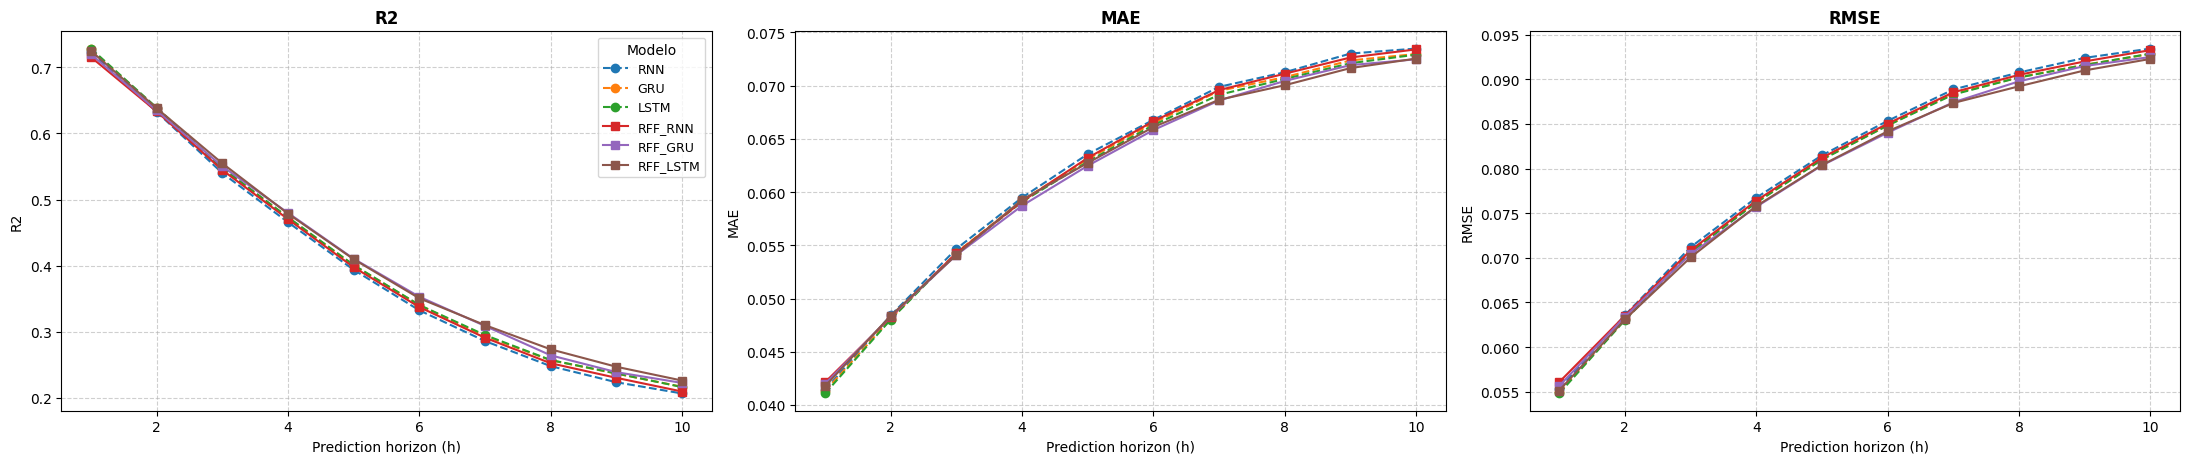

In [47]:
import matplotlib.pyplot as plt

metrics = ["R2", "MAE", "RMSE"]

# === NUEVO: Obtener los datos del diccionario maestro ===
df_pointwise_all = experiment_results["global"]["pointwise_all"]

fig, axes = plt.subplots(1, 3, figsize=(22, 5))
plt.subplots_adjust(wspace=0.3)

for i, metric in enumerate(metrics):
    ax = axes[i]

    # ----- Modelos SIN RFF -----
    for name in ["RNN", "GRU", "LSTM"]:
        subset = df_pointwise_all[df_pointwise_all["model"] == name]
        if not subset.empty:
            ax.plot(
                subset["horizon"],
                subset[metric],
                linestyle="--",
                marker='o',
                label=f"{name}"
            )

    # ----- Modelos CON RFF -----
    for name in ["RFF_RNN", "RFF_GRU", "RFF_LSTM"]:
        subset = df_pointwise_all[df_pointwise_all["model"] == name]
        if not subset.empty:
            ax.plot(
                subset["horizon"],
                subset[metric],
                linestyle="-",
                marker='s',
                label=name
            )

    ax.set_title(metric, fontsize=12, fontweight="bold")
    ax.set_xlabel("Prediction horizon (h)")
    ax.set_ylabel(metric)
    ax.grid(True, linestyle="--", alpha=0.6)

    if i == 0:
        ax.legend(title="Modelo", fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

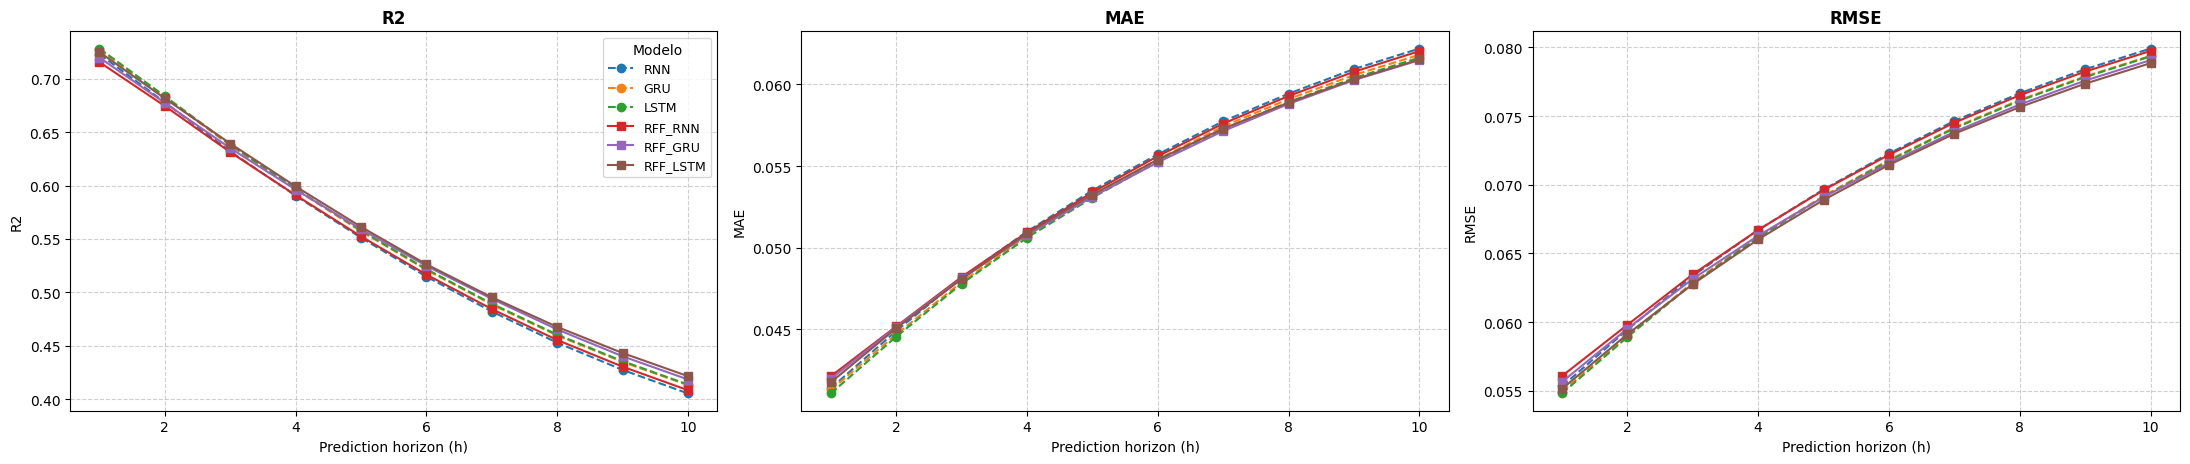

In [48]:
import matplotlib.pyplot as plt

# ===========================================================
# OBTENER LOS DATOS DESDE experiment_results
# ===========================================================
df_pointwise_all = experiment_results["global"]["pointwise_all"].copy()

metrics = ["R2", "MAE", "RMSE"]

# ===========================================================
# CONSTRUIR VERSION ACUMULADA PARA GRAFICAR
# ===========================================================
df_cumulative_plot = (
    df_pointwise_all
    .sort_values(["model", "horizon"])
    .groupby("model", group_keys=False)
    .apply(lambda g: g.assign(
        R2=g["R2"].expanding().mean(),
        MAE=g["MAE"].expanding().mean(),
        RMSE=g["RMSE"].expanding().mean()
    ))
)

# ===========================================================
# FIGURA MULTIPANEL
# ===========================================================
fig, axes = plt.subplots(1, 3, figsize=(22, 5))
plt.subplots_adjust(wspace=0.3)

for i, metric in enumerate(metrics):
    ax = axes[i]

    # ----- Modelos SIN RFF -----
    for name in ["RNN", "GRU", "LSTM"]:
        subset = df_cumulative_plot[df_cumulative_plot["model"] == name]
        if not subset.empty:
            ax.plot(
                subset["horizon"],
                subset[metric],
                linestyle="--",
                marker='o',
                label=f"{name}"
            )

    # ----- Modelos CON RFF -----
    for name in ["RFF_RNN", "RFF_GRU", "RFF_LSTM"]:
        subset = df_cumulative_plot[df_cumulative_plot["model"] == name]
        if not subset.empty:
            ax.plot(
                subset["horizon"],
                subset[metric],
                linestyle="-",
                marker='s',
                label=name
            )

    # Etiquetas y estilo
    ax.set_title(metric, fontsize=12, fontweight="bold")
    ax.set_xlabel("Prediction horizon (h)")
    ax.set_ylabel(metric)
    ax.grid(True, linestyle="--", alpha=0.6)

    if i == 0:
        ax.legend(title="Modelo", fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



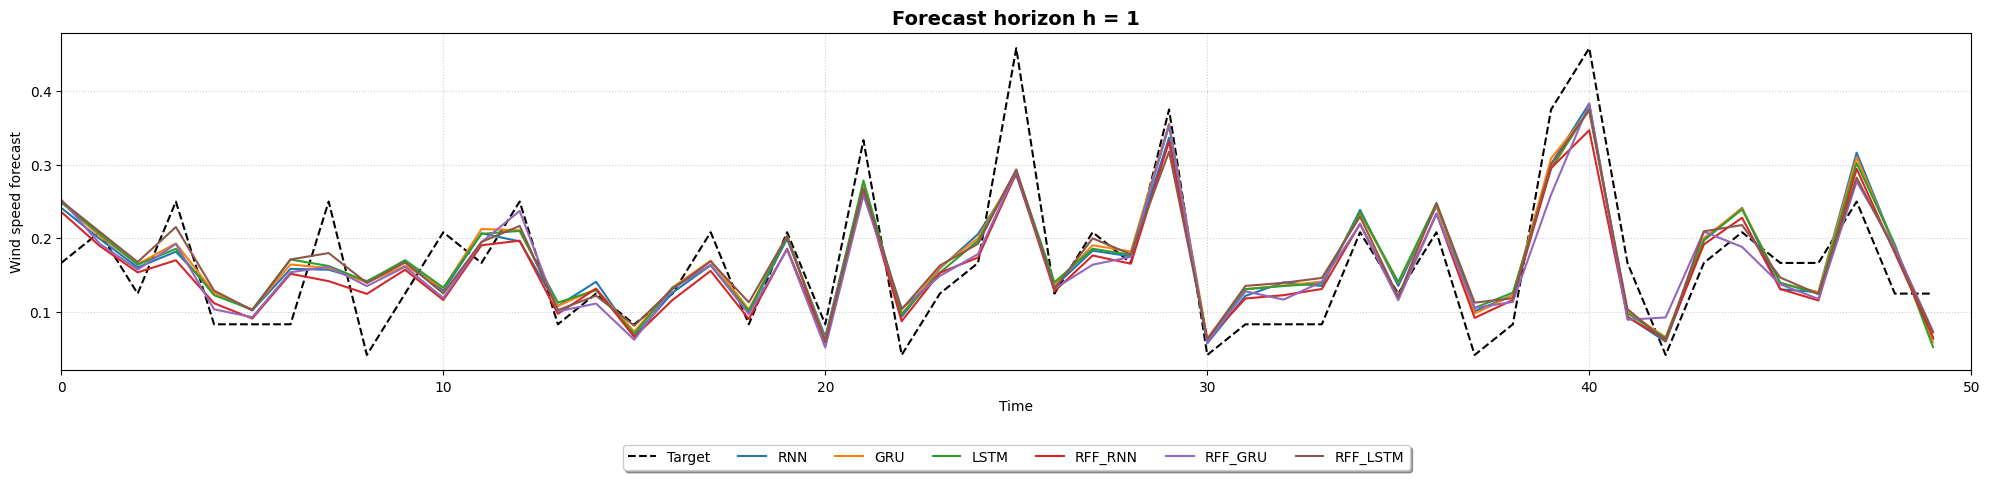

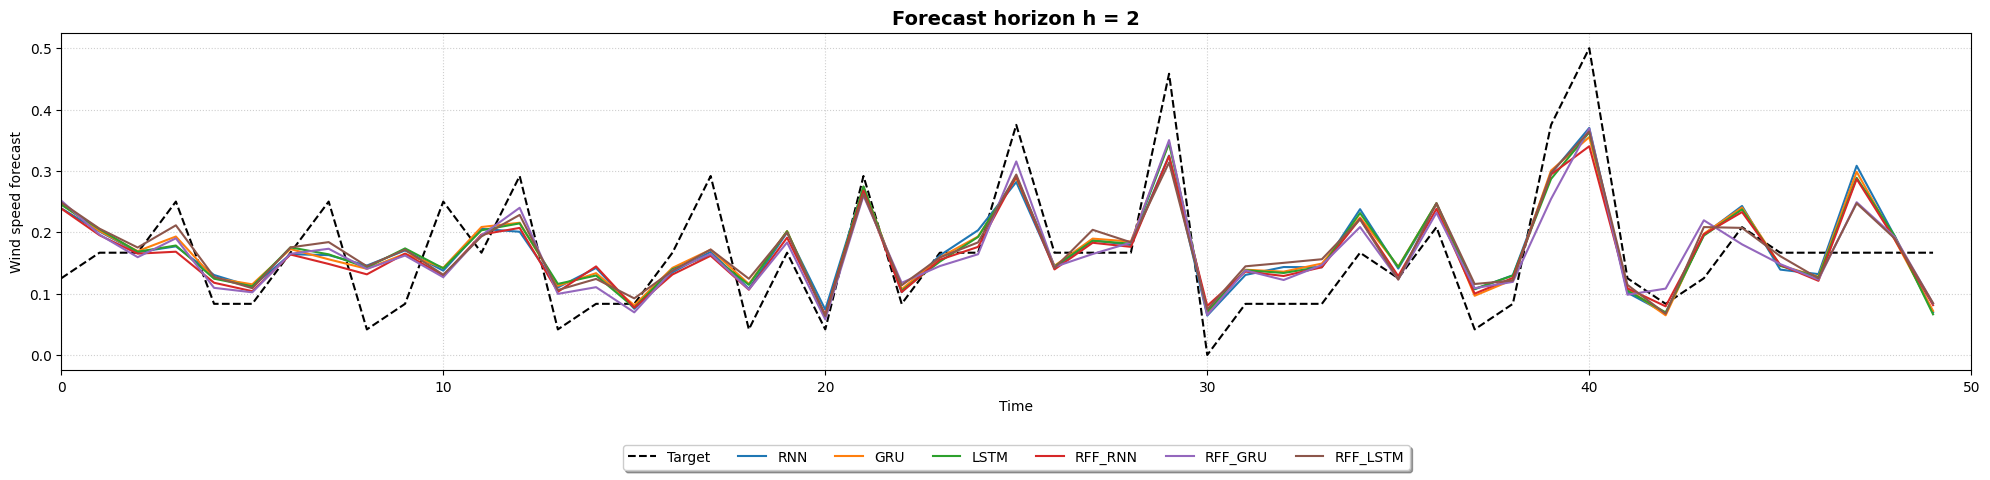

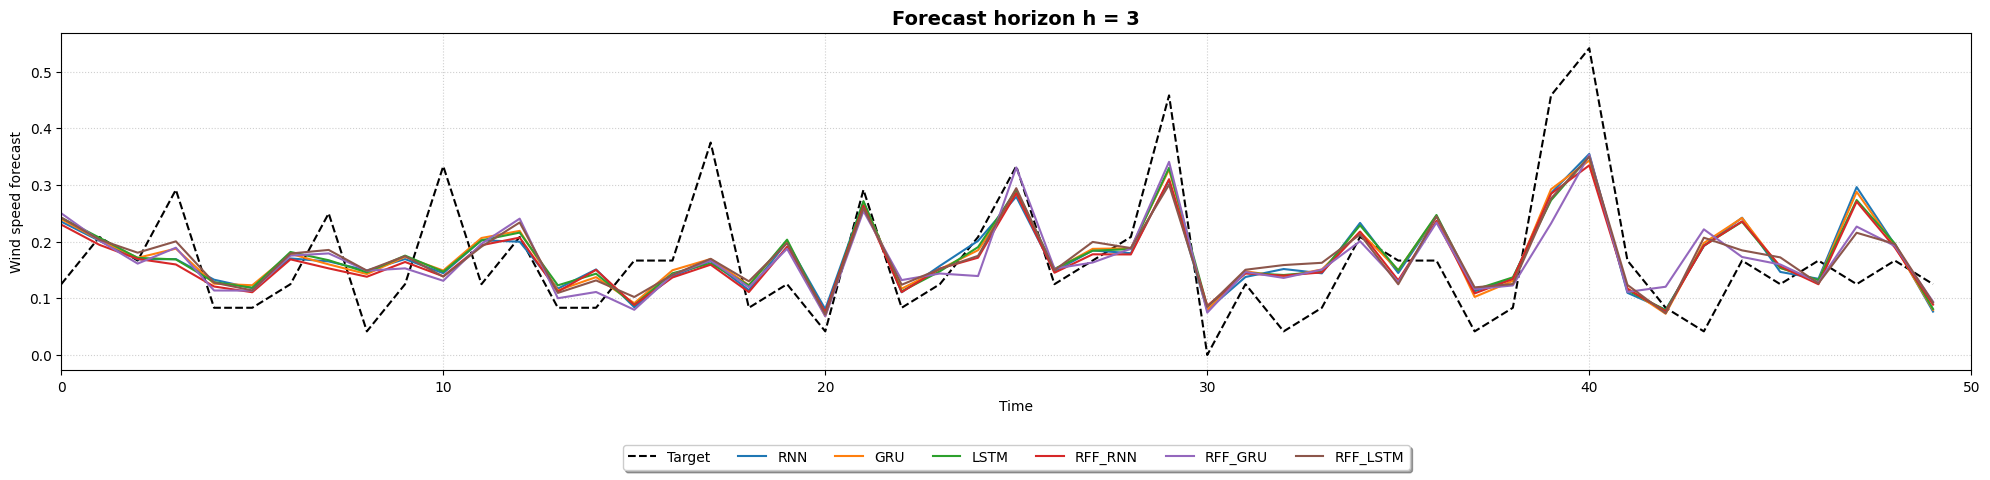

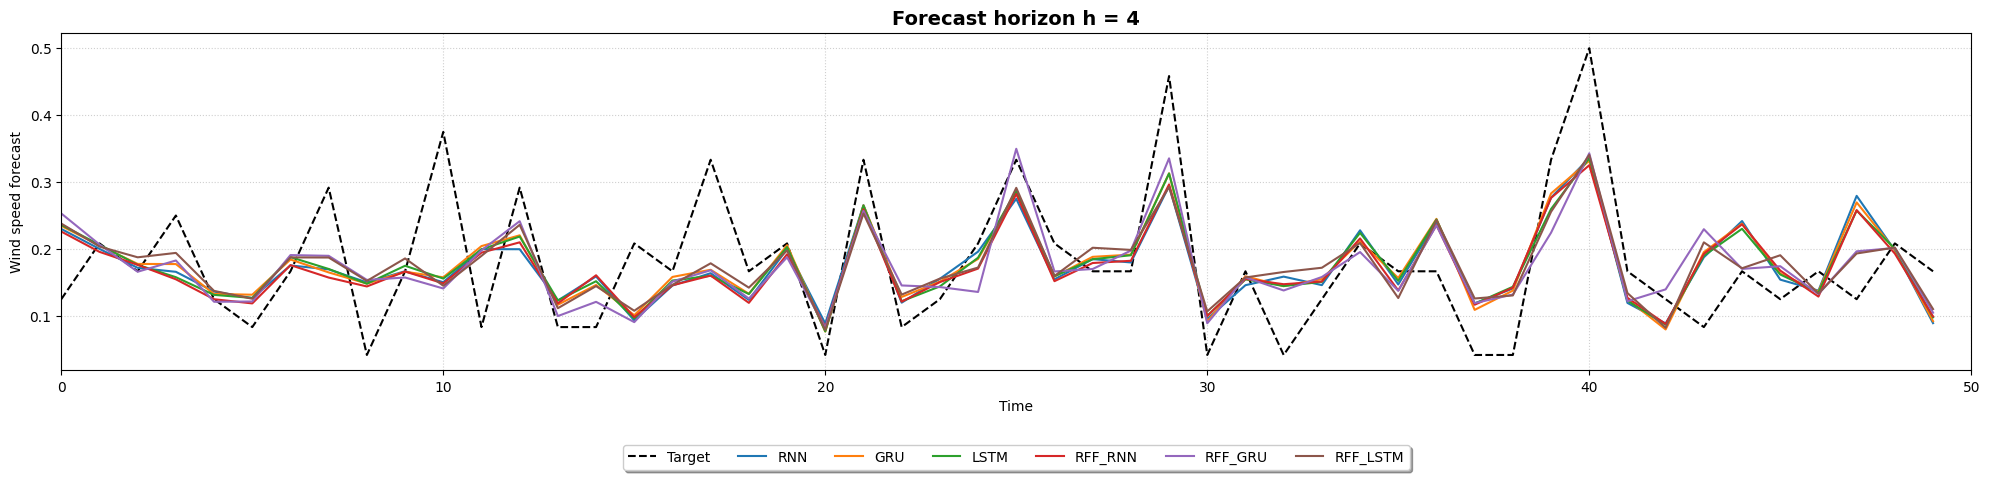

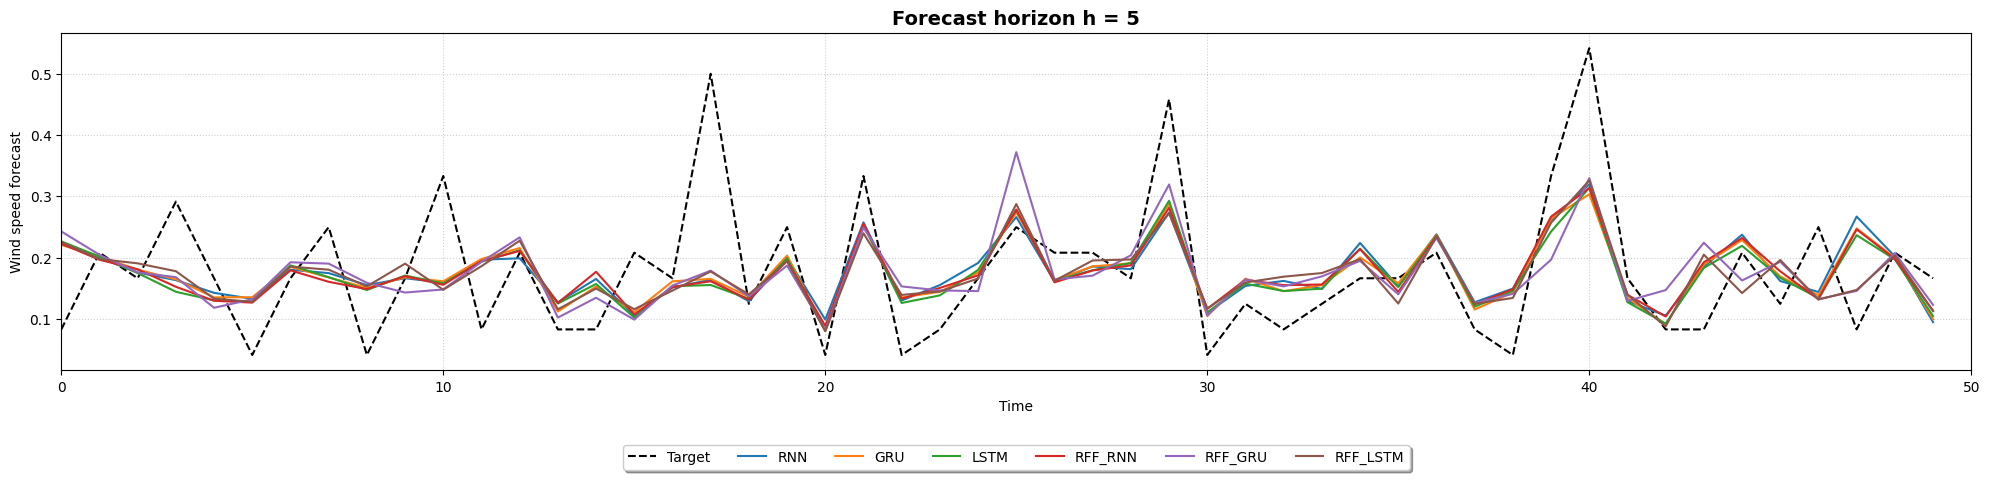

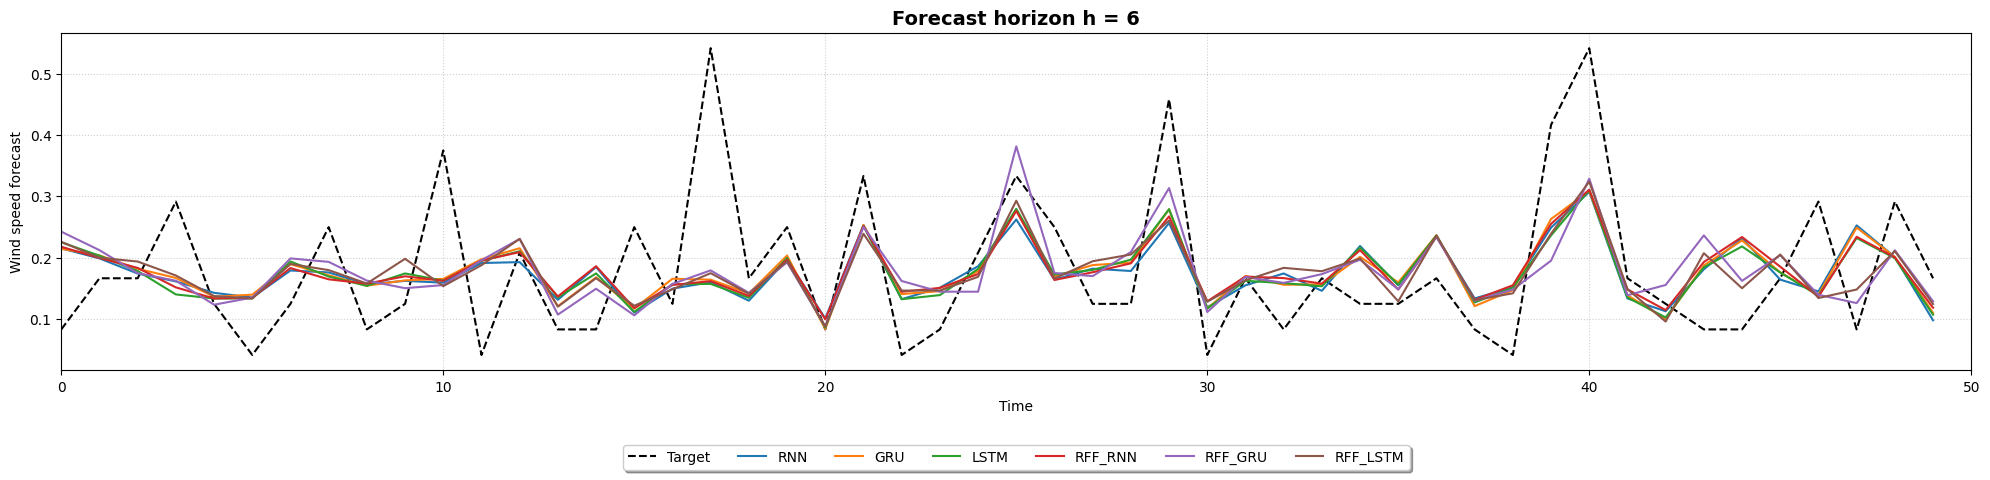

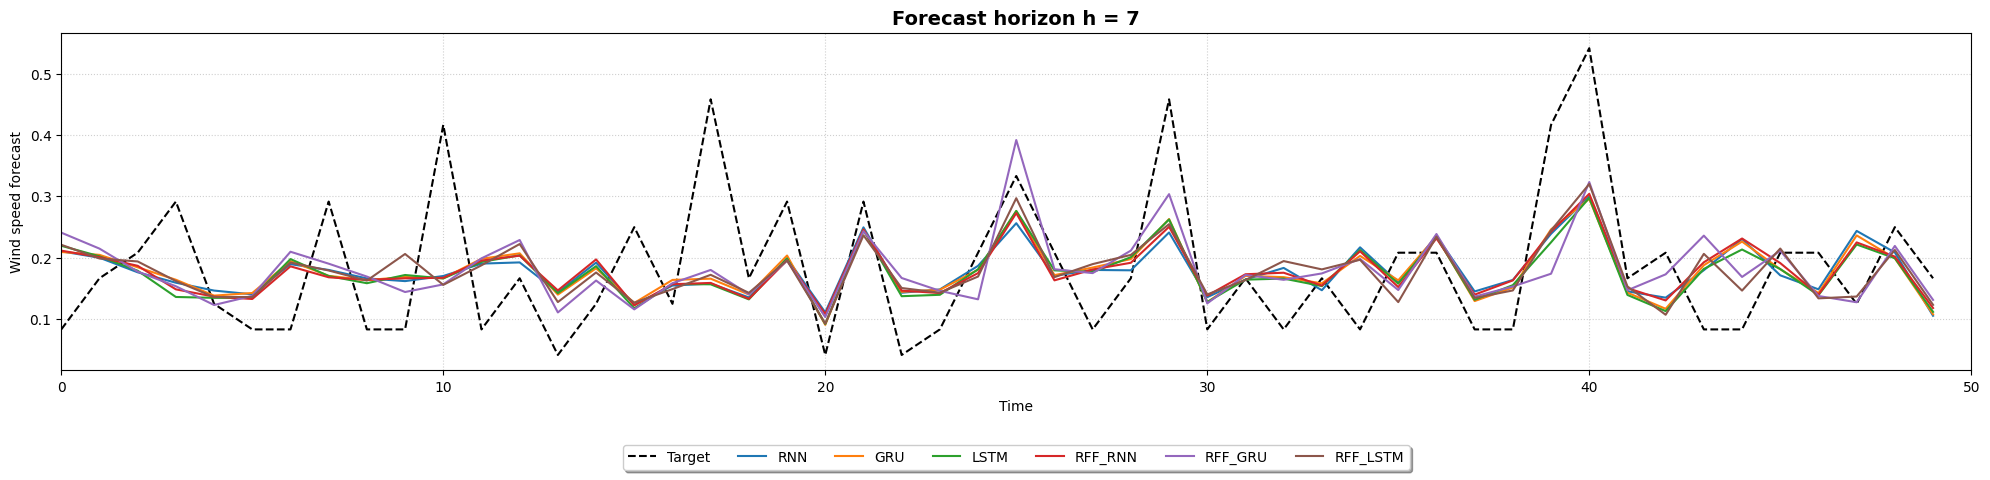

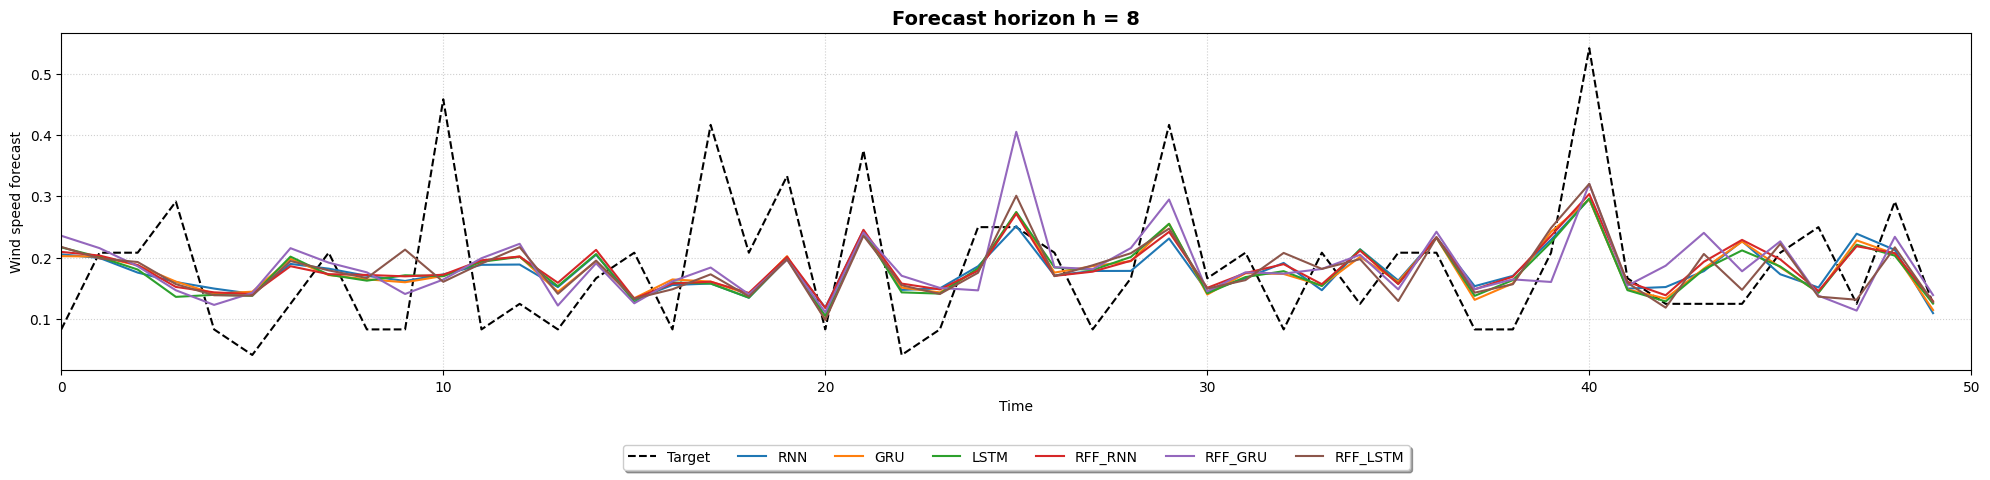

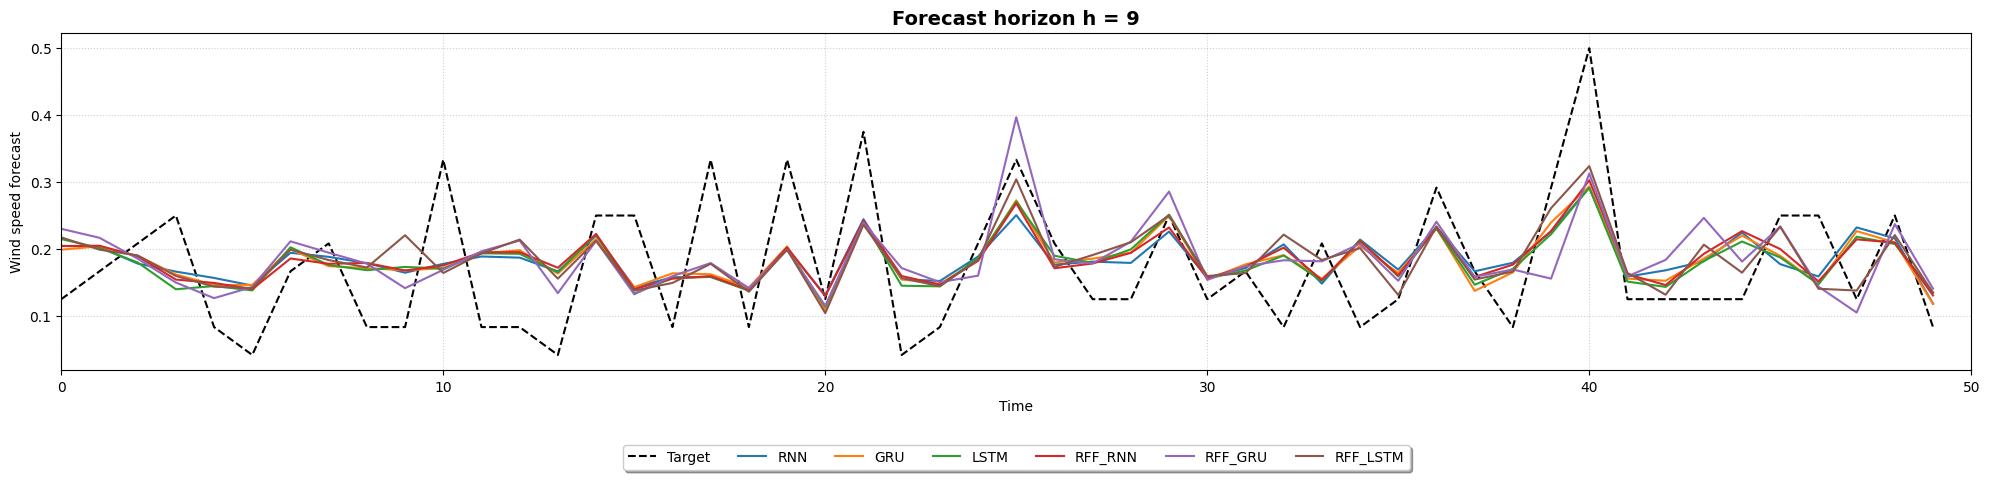

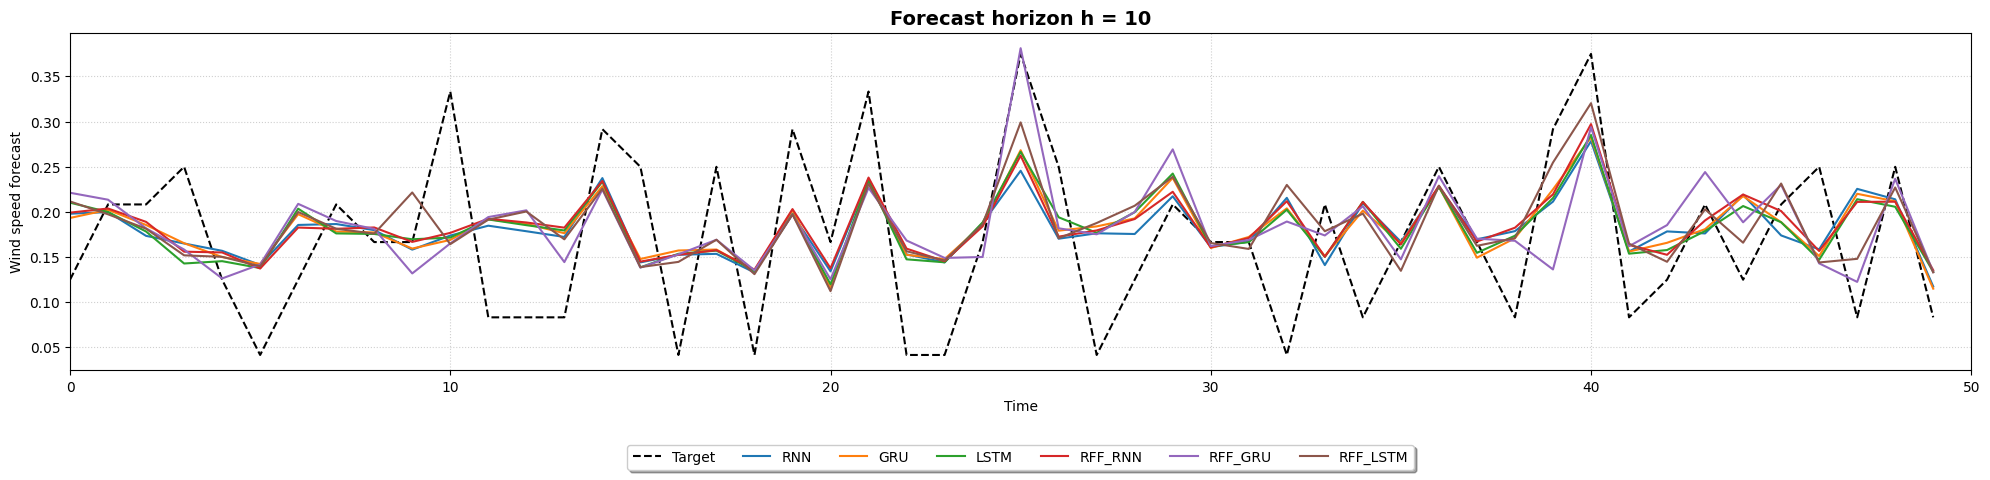

In [49]:
# ===========================================================
# GRAFICAR PRONÓSTICOS POR HORIZONTE (H pasos adelante)
# ===========================================================

H = experiment_results["config"]["models_included"][0]  # o el valor que tú uses para horizon
# Si horizon está en args:
H = list(experiment_results["models"].values())[0]["args"]["horizon"]

# Acceder a los pronósticos
forecast_dict = {
    model_name: (
        model_info["forecast"]["y_true"],
        model_info["forecast"]["y_pred"]
    )
    for model_name, model_info in experiment_results["models"].items()
}

for i in range(H):
    plt.figure(figsize=(20, 5))
    target_plotted = False

    for model_name, (y_true_data, y_pred_data) in forecast_dict.items():

        # Recuperar y_true una sola vez
        if not target_plotted:
            y_true = y_true_data[0:50, i]        # primeros 50 puntos
            plt.plot(y_true, label="Target",
                     linestyle='dashed', color='black')
            target_plotted = True

        # Predicción del modelo
        y_pred = y_pred_data[0:50, i]
        plt.plot(y_pred, label=model_name)

    # ===== CONFIGURACIÓN DEL GRÁFICO =====
    plt.xlim(0, 50)
    plt.xlabel("Time")
    plt.ylabel("Wind speed forecast")
    plt.title(f"Forecast horizon h = {i+1}", fontsize=14, fontweight="bold")

    # leyenda centrada abajo
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.2),
        ncol=len(forecast_dict) + 1,
        fancybox=True,
        shadow=True
    )

    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

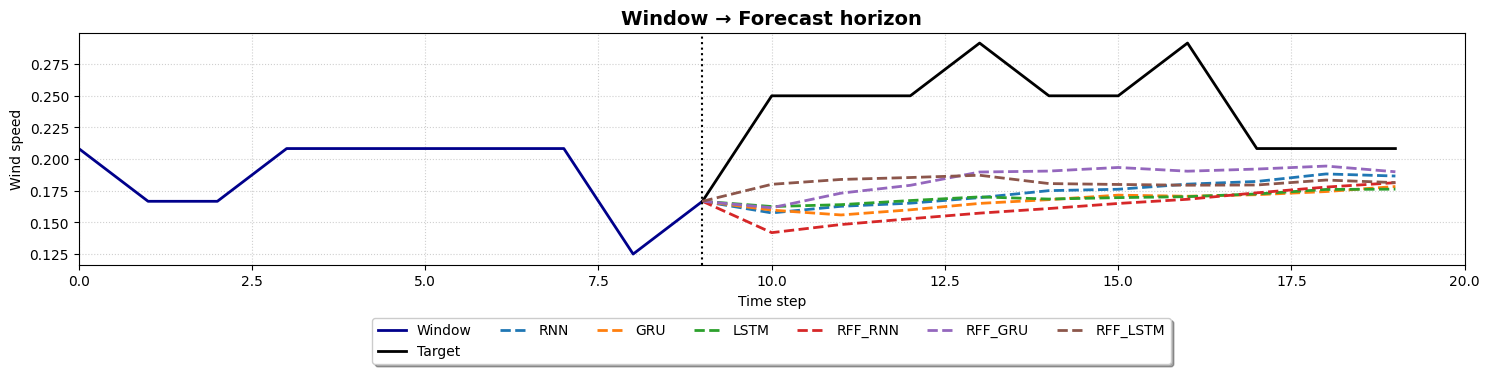

In [50]:
from sklearn.utils import TargetTags
test_loader = data[folder_name]['loaders']['test']
X_batch, Y_batch = next(iter(test_loader))
batch_index = 7  # punto de prueba a graficar

# Número de pasos de entrada
L_in = 20

# ===========================================================
# 1. RECUPERAR EL VALOR MAX PARA ESCALAR
# ===========================================================
max_value = data_dict_loaded[names_TSF[0]]['Max']

# ===========================================================
# 2. EXTRAER LA SERIE DE ENTRADA DEL BATCH SELECCIONADO
# ===========================================================
input_ts = X_batch[batch_index, :, 0].numpy() * max_value
time = np.arange(0, input_ts.shape[0] + H + 1, 1)

plt.figure(figsize=(15, 4))

# Plot ventana de entrada
time_input = time[:input_ts.shape[0]]
plt.plot(time_input, input_ts, label='Window', color='darkblue', linewidth=2)

# ===========================================================
# 3. DICCIONARIO DE PRONÓSTICOS
# ===========================================================
forecast_dict = {
    model_name: (
        model_info["forecast"]["y_true"],
        model_info["forecast"]["y_pred"]
    )
    for model_name, model_info in experiment_results["models"].items()
}

# ===========================================================
# 4. PLOT DEL TARGET + PLOTS DE CADA MODELO
# ===========================================================
flag = 0

for model_name, (y_true_data, y_pred_data) in forecast_dict.items():

    if flag == 0:
        # ------- TARGET -------
        target = y_true_data[batch_index, :] * max_value
        time_target = time[input_ts.shape[0] - 1 : input_ts.shape[0] + H]
        y_input_target = np.concatenate(([input_ts[-1]], target))

        plt.plot(time_target, y_input_target,
                 label='Target', color='black', linewidth=2)
        flag = 1  # para que solo se grafique una vez

    # ------- PRONÓSTICO DEL MODELO -------
    output = y_pred_data[batch_index, :] * max_value
    time_forecast = time[input_ts.shape[0] - 1 : input_ts.shape[0] + H]
    y_forecast = np.concatenate(([input_ts[-1]], output))

    plt.plot(
        time_forecast,
        y_forecast,
        label=model_name,
        linestyle='--',
        linewidth=2
    )

# ===========================================================
# 5. LÍNEA VERTICAL SEPARANDO INPUT Y FORECAST
# ===========================================================
plt.axvline(
    x=input_ts.shape[0] - 1,
    color='black',
    linestyle=':',
    linewidth=1.5
)

# ===========================================================
# 6. CONFIGURACIÓN FINAL DEL GRÁFICO
# ===========================================================
plt.title("Window → Forecast horizon", fontsize=14, fontweight='bold')
plt.xlabel("Time step")
plt.ylabel("Wind speed")

plt.xlim(0, time[-1])

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=len(forecast_dict) + 1,
    fancybox=True,
    shadow=True
)

plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()